# Laboratorio 1 de Aprendizaje Automatico SVM 
Nombre: David Valero Croma
Profesora: Violeta Chang Camacho
Ayudante: Clemente Aguilar Osorio

## Preeliminares
Aquí se realizan los import, cargan los archivos de las imagenes y preprocesamiento de los datos (vectores, vectores-pca, vectores-umap).

In [2]:
#Imports
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import umap
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
#Cargamos archivos

# Rutas
ROOT_DIR = "QuickDraw-10"
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
TRAIN_PATH = os.path.join(ROOT_DIR, "train.txt")
TEST_PATH = os.path.join(ROOT_DIR, "test.txt")
MAPPING_PATH = os.path.join(ROOT_DIR, "mapping.txt")

# Cargar mapping
mapping_df = pd.read_csv(MAPPING_PATH, sep="\t", header=None, names=["class", "label"])
label2name = dict(zip(mapping_df.label, mapping_df["class"]))
name2label = dict(zip(mapping_df["class"], mapping_df.label))

#Funcion para cargar el dataset y dejar cada imagen en un array de 65536 elementos
def load_dataset(txt_file):
    X, y = [], []
    with open(txt_file, 'r') as f:
        for line in f:
            rel_path, label = line.strip().split('\t')
            full_path = os.path.join(ROOT_DIR, rel_path)
            img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                X.append(img.flatten())  # vector de 256x256 → 65536
                y.append(int(label))
    return np.array(X), np.array(y)

# Carga
X_train, y_train = load_dataset(TRAIN_PATH)
X_test, y_test = load_dataset(TEST_PATH)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (9834, 65536), Test shape: (1166, 65536)


In [4]:
def aplicar_pca(X_train, X_test, n_componentes=256):
    pca = PCA(n_components=n_componentes, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


def aplicar_umap(X_train, X_test, n_componentes=256):
    umap_model = umap.UMAP(n_components=n_componentes)
    X_train_umap = umap_model.fit_transform(X_train)
    X_test_umap = umap_model.transform(X_test)
    return X_train_umap, X_test_umap, umap_model


In [5]:
def entrenar_svm(X_train, y_train, kernel='rbf', C=10.0, gamma='scale'):
    clf = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
    clf.fit(X_train, y_train)
    return clf

## Modelo SVM
Aquí se definen las funciones que permitiran trabajar la tecnica de svm con diferentes parametros e hiperparametros y evaluar su desempeño.

In [6]:
def evaluar_modelo(modelo, X_test, y_test, label2name):
    """
    Evalúa el modelo y entrega métricas de desempeño.

    Parámetros:
    - modelo: modelo SVM ya entrenado
    - X_test: datos de prueba
    - y_test: etiquetas de prueba
    - label2name: diccionario de id → nombre clase

    Retorna:
    - accuracy_total: precisión global
    - accuracy_por_clase: diccionario clase → accuracy
    - y_pred: predicciones
    """
    y_pred = modelo.predict(X_test)
    accuracy_total = accuracy_score(y_test, y_pred)

    reporte = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy_por_clase = {label2name[int(k)]: v['precision'] for k, v in reporte.items() if k.isdigit()}

    return accuracy_total, accuracy_por_clase, y_pred

In [7]:
def graficar_accuracy_por_clase(accuracy_dict, titulo):
    """
    Grafica accuracy por clase.

    Parámetros:
    - accuracy_dict: diccionario clase → valor de accuracy
    - titulo: título del gráfico
    """
    clases = list(accuracy_dict.keys())
    valores = list(accuracy_dict.values())

    plt.figure(figsize=(10, 5))
    plt.bar(clases, valores)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(titulo)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
def mostrar_matriz_confusion(y_true, y_pred, label2name, titulo="Matriz de Confusión"):
    """
    Genera y grafica la matriz de confusión para clasificación multiclase.

    Parámetros:
    - y_true: etiquetas verdaderas
    - y_pred: etiquetas predichas
    - label2name: diccionario de clase (int) → nombre (str)
    """
    etiquetas = [label2name[i] for i in sorted(label2name.keys())]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=etiquetas, yticklabels=etiquetas, cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(titulo)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
def probar_modelo(X_train, y_train, X_test, y_test, kernel, label2name, nombre="", C = 10.0):
    """
    Entrena y evalúa un modelo SVM con kernel especificado y muestra métricas.

    Parámetros:
    - X_train, y_train, X_test, y_test: datos
    - kernel: tipo de kernel ('rbf', 'linear', 'poly', etc.)
    - label2name: diccionario clase → nombre
    - nombre: etiqueta para mostrar en los resultados
    """
    start = time.time()
    print(f"\n--- {nombre} ---")
    modelo = entrenar_svm(X_train, y_train, kernel=kernel, C = C)
    acc_total, acc_clase, y_pred = evaluar_modelo(modelo, X_test, y_test, label2name)

    print(f"Accuracy total: {acc_total:.4f}  || Tiempo total: {(time.time() - start):.4f}")
    graficar_accuracy_por_clase(acc_clase, f"Accuracy por clase - {nombre}")
    mostrar_matriz_confusion(y_test, y_pred, label2name, f"Matriz Confusión - {nombre}")
    return modelo, acc_total, acc_clase, y_pred

## Experimentos
Aqui se realizan los experimentos con diferentes kernels, preprocemsamientos de info. y se muestran los gráficos correspondientes a las comparativas tanto de precisión total, por clase, matriz de confusión y el tiempo de ejecución. 


--- Original - RBF ---
Accuracy total: 0.7247  || Tiempo total: 2699.8492


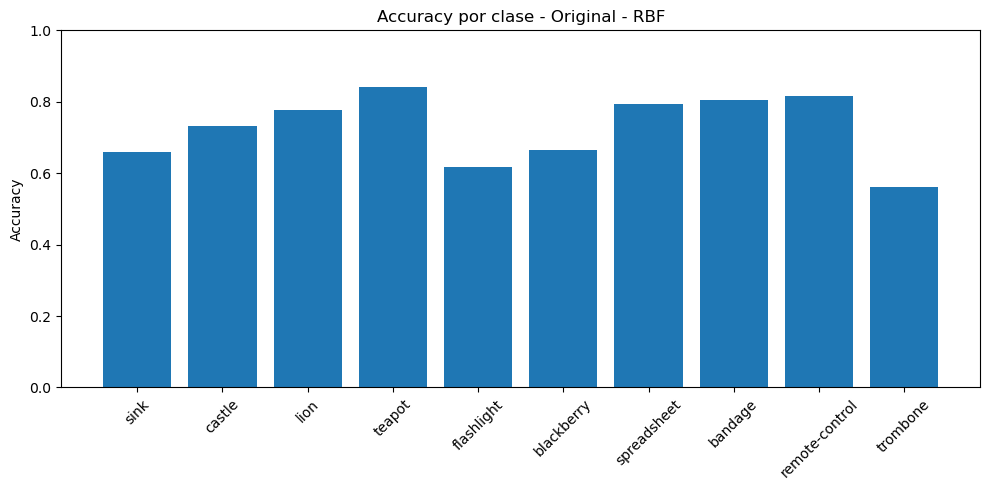

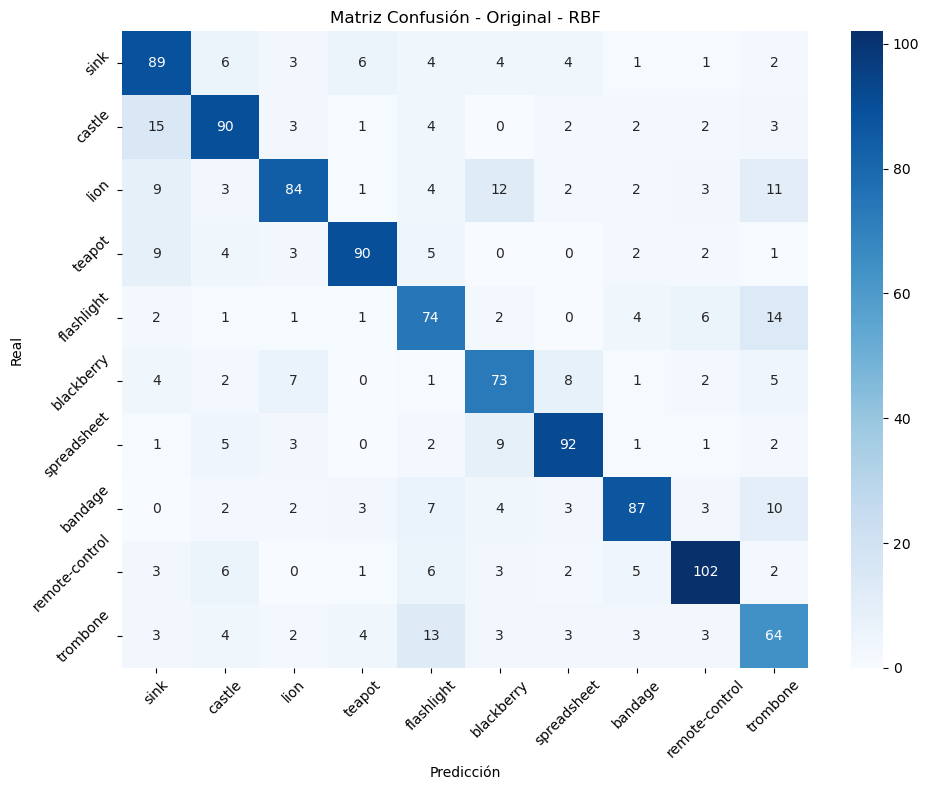


-------------------------------------------------------------------------------


--- Original - Poly ---
Accuracy total: 0.6089  || Tiempo total: 1244.3887


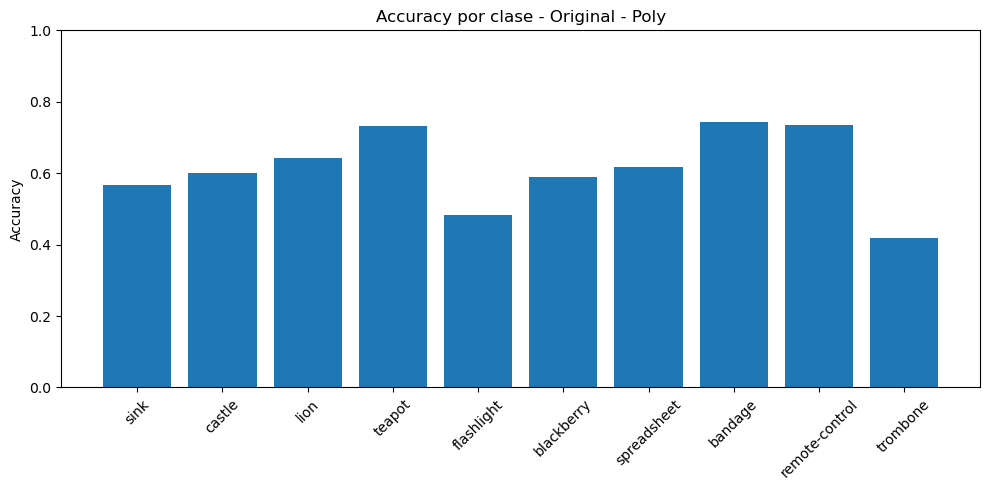

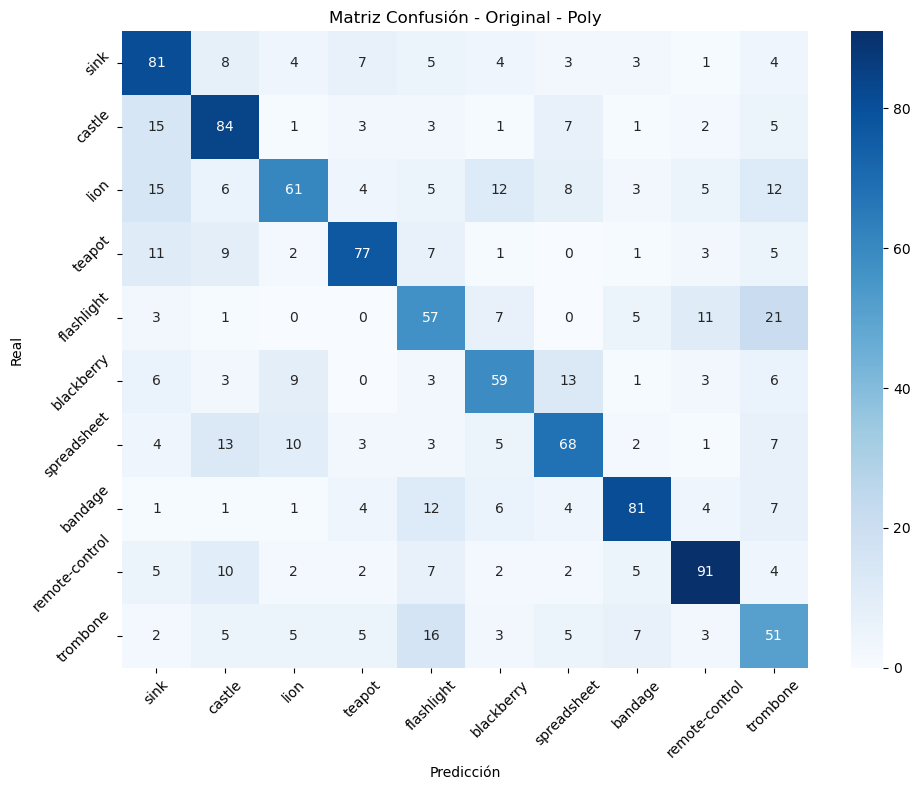

In [14]:
#Entrenar con imágenes originales
modelo_rbf, acc_rbf, acc_clase_rbf, y_pred_rbf = probar_modelo(X_train, y_train, X_test, y_test, 'rbf', label2name, "Original - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_poly, acc_poly, acc_clase_poly, y_pred_poly = probar_modelo(X_train, y_train, X_test, y_test, 'poly', label2name, "Original - Poly")


--- PCA - RBF ---
Accuracy total: 0.7736  || Tiempo total: 11.2948


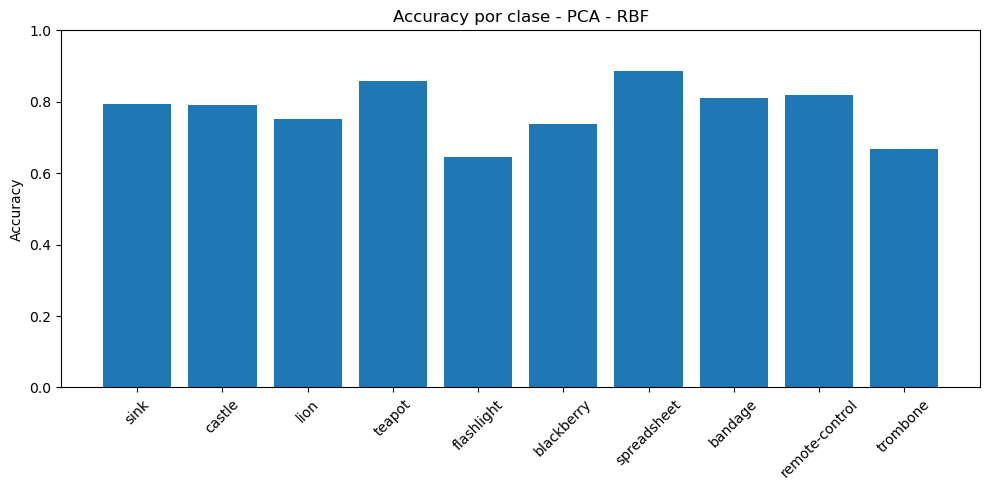

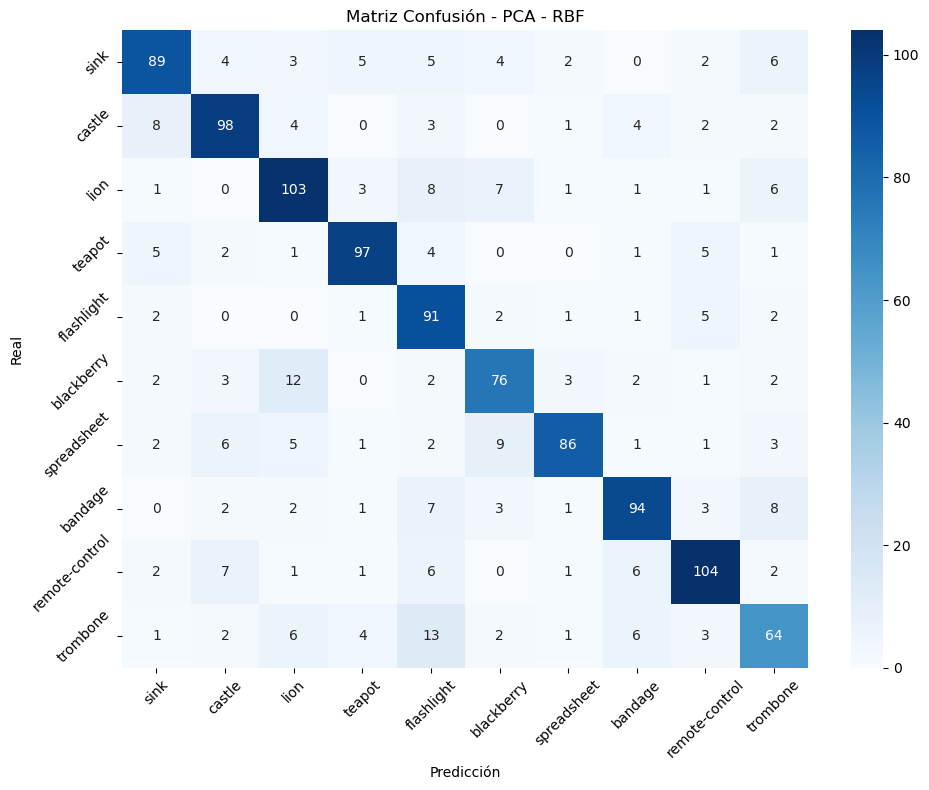


-------------------------------------------------------------------------------


--- PCA - Poly ---
Accuracy total: 0.7187  || Tiempo total: 11.9958


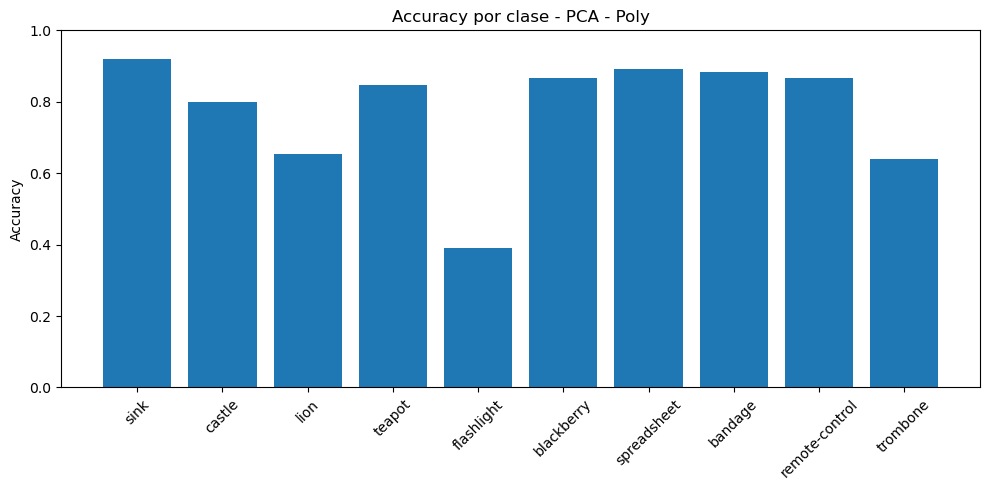

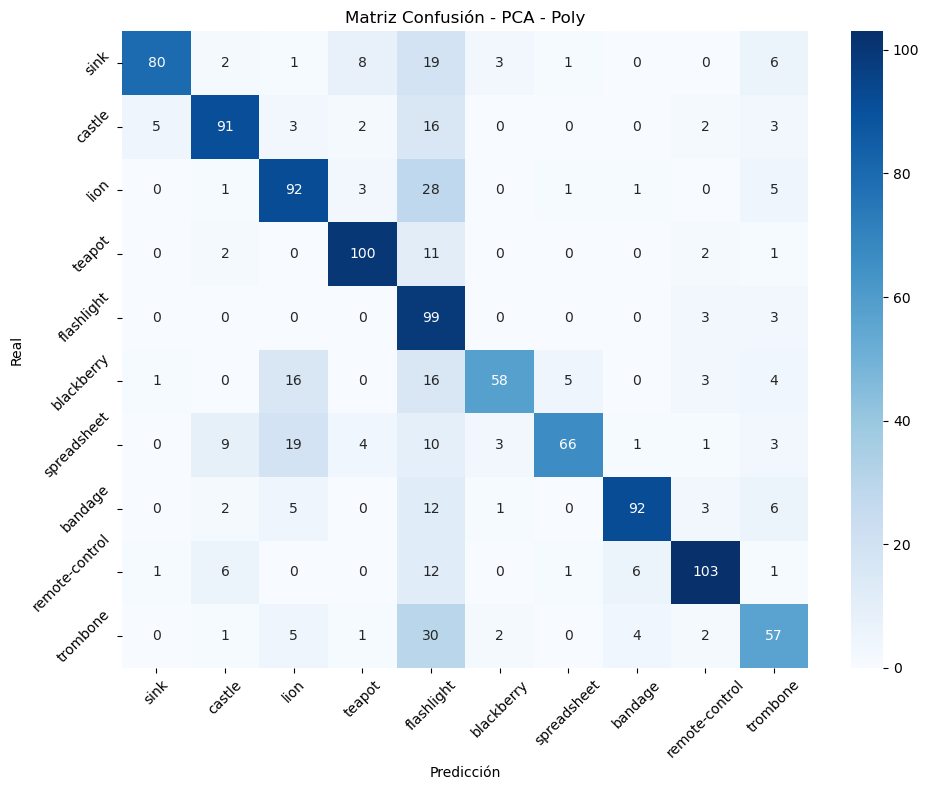

In [11]:
#PCA
X_train_pca, X_test_pca, modelo_pca = aplicar_pca(X_train, X_test, n_componentes=256)

modelo_pca_RBF, acc_pca_rbf, acc_clase_pca_rbf, y_pred_pca_rbf = probar_modelo(X_train_pca, y_train, X_test_pca, y_test, 'rbf', label2name, "PCA - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_poly, acc_pca_poly, acc_clase_pca_poly, y_pred_pca_poly = probar_modelo(X_train_pca, y_train, X_test_pca, y_test, 'poly', label2name, "PCA - Poly")


--- UMAP - RBF ---
Accuracy total: 0.2839  || Tiempo total: 7.6205


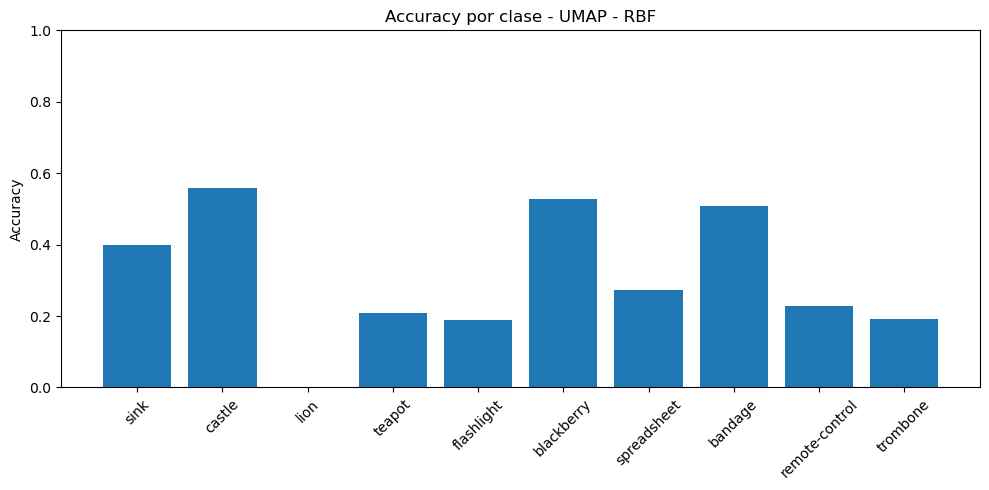

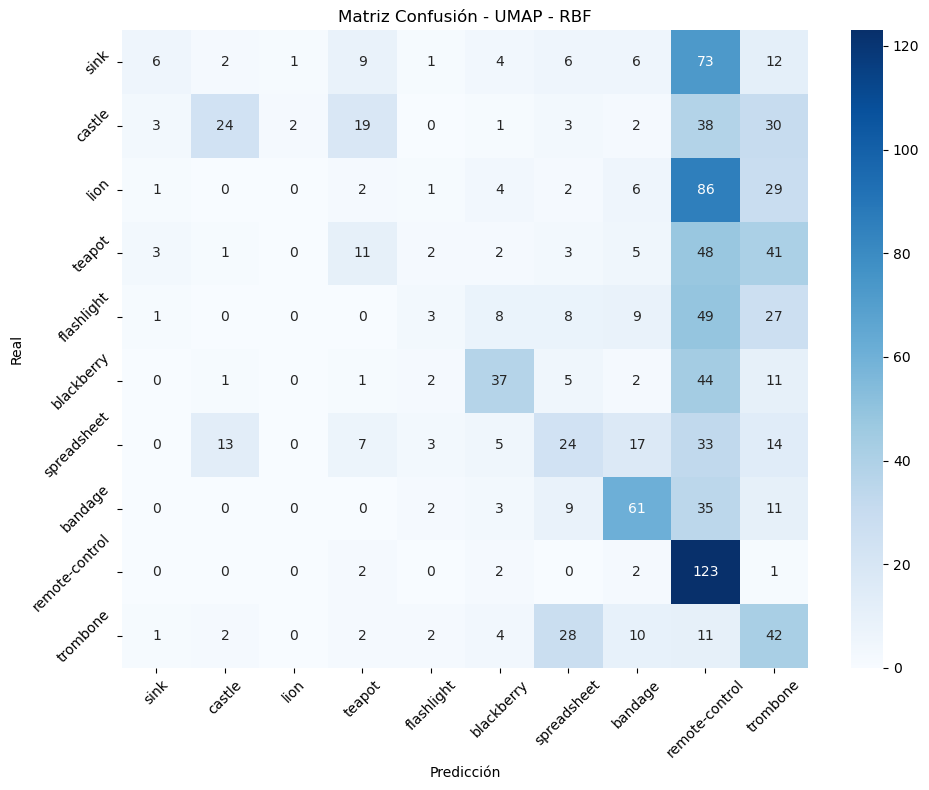


-------------------------------------------------------------------------------


--- UMAP - Poly ---
Accuracy total: 0.2976  || Tiempo total: 6.2301


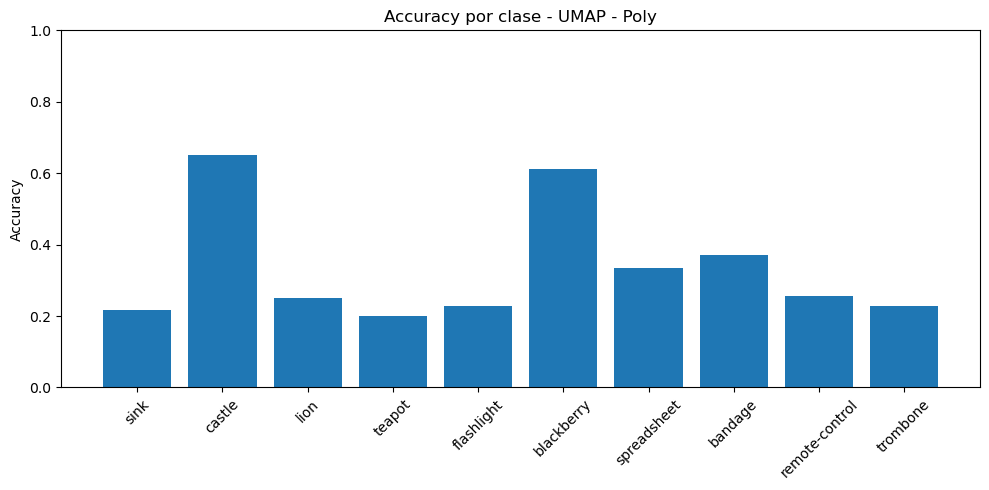

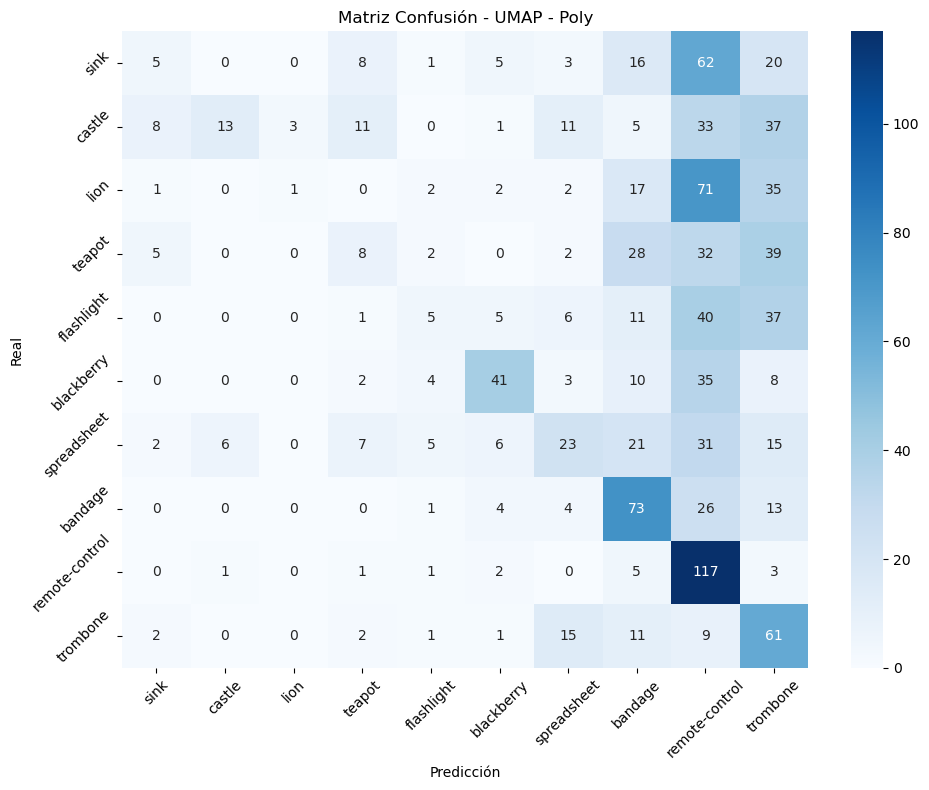

In [16]:
#UMAP
X_train_umap, X_test_umap, modelo_umap = aplicar_umap(X_train, X_test, n_componentes=256)

modelo_umap_RBF, acc_umap_rbf, acc_clase_umap_rbf, y_pred_umap_rbf = probar_modelo(X_train_umap, y_train, X_test_umap, y_test, 'rbf', label2name, "UMAP - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_poly, acc_umap_poly, acc_clase_umap_poly, y_pred_umap_poly = probar_modelo(X_train_umap, y_train, X_test_umap, y_test, 'poly', label2name, "UMAP - Poly")

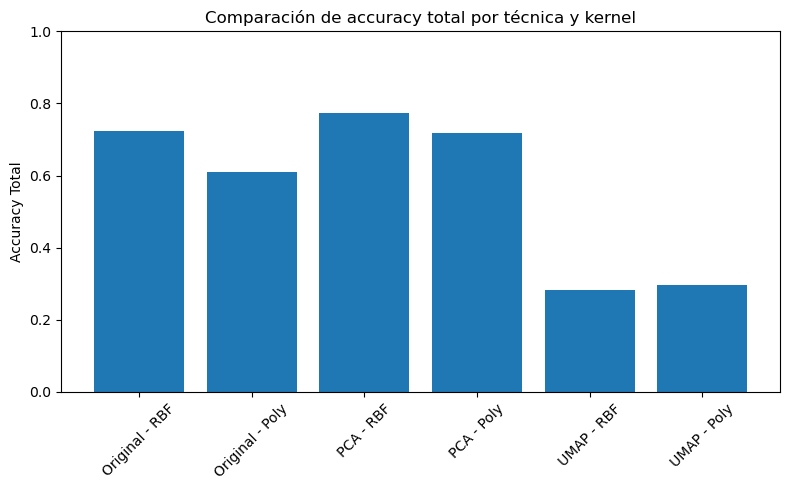

In [17]:
# Accuracy total por enfoque y kernel
resultados_totales = {
    "Original - RBF": acc_rbf,
    "Original - Poly": acc_poly,
    "PCA - RBF": acc_pca_rbf,
    "PCA - Poly": acc_pca_poly,
    "UMAP - RBF": acc_umap_rbf,
    "UMAP - Poly": acc_umap_poly
}

# Gráfico resumen
plt.figure(figsize=(8, 5))
plt.bar(resultados_totales.keys(), resultados_totales.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy Total")
plt.title("Comparación de accuracy total por técnica y kernel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Experimentos extra.
Aquí se deja registro de experimentos realizados para comprobar si se puede mejorar el rendimiento de las combinaciones, preprocesamiento y kernel svm, mediante cambios en los parametros o hiperparametros. 

### Variación en Dim Umap
Se hacen pruebas variando el número de componentes en umap (10,50,100)


--- UMAP - RBF ---
Accuracy total: 0.2847  || Tiempo total: 3.5507


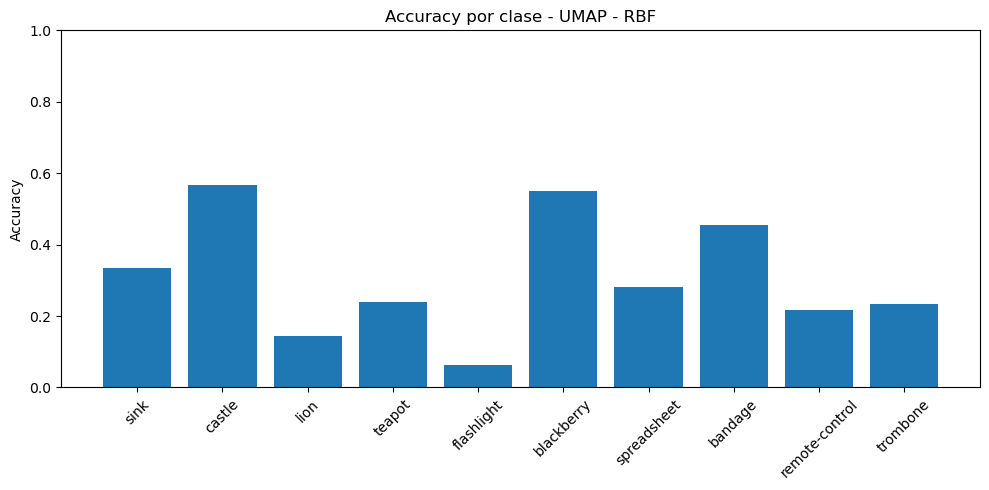

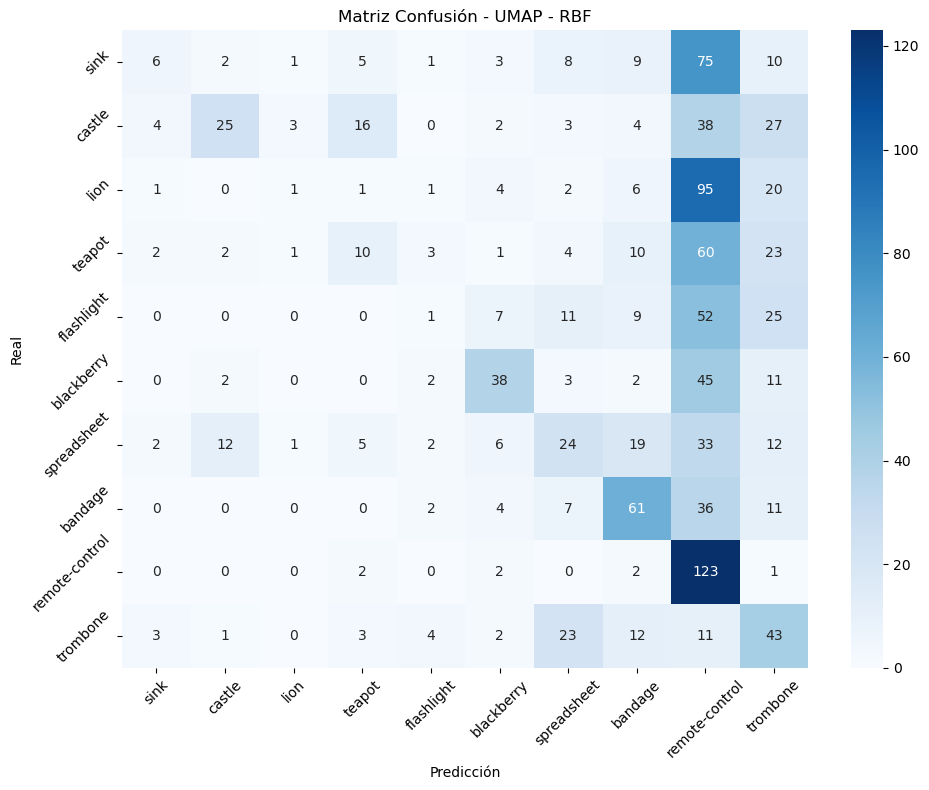


-------------------------------------------------------------------------------


--- UMAP - Poly ---
Accuracy total: 0.2779  || Tiempo total: 2.1932


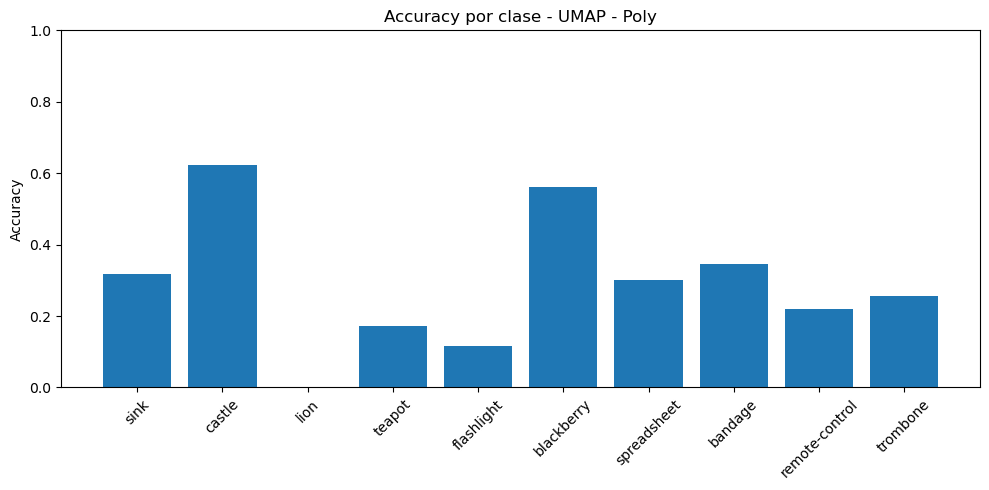

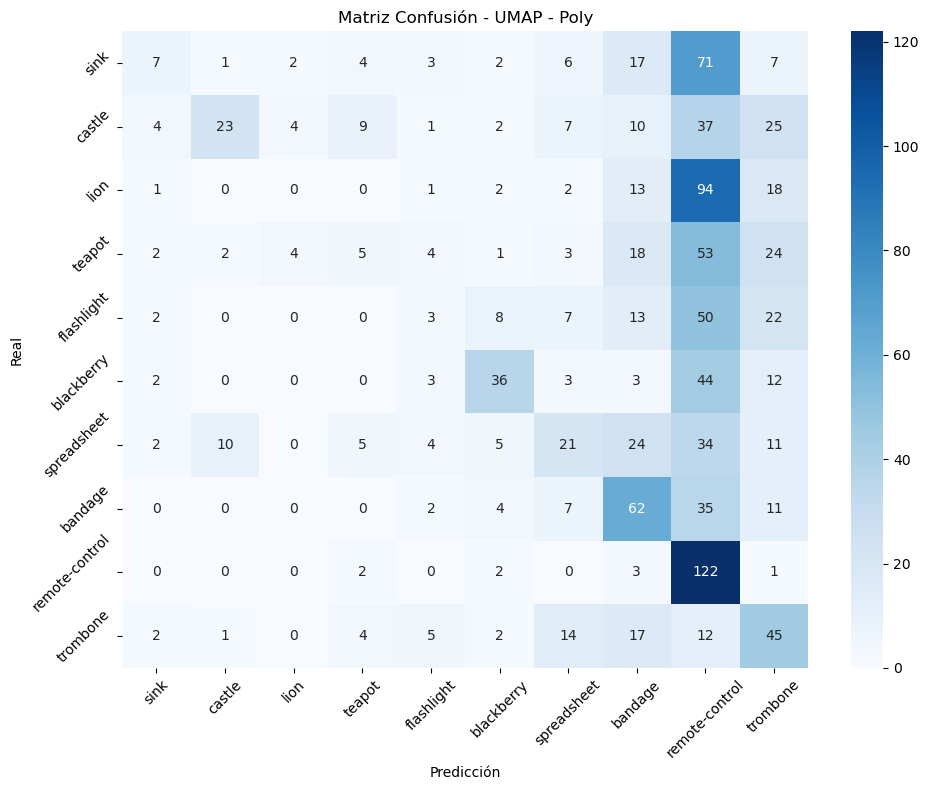

In [19]:
#UMAP
X_train_umap1, X_test_umap1, modelo_umap1 = aplicar_umap(X_train, X_test, n_componentes=10)

modelo_umap_RBF1, acc_umap_rbf1, acc_clase_umap_rbf1, y_pred_umap_rbf1 = probar_modelo(X_train_umap1, y_train, X_test_umap1, y_test, 'rbf', label2name, "UMAP - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_poly1, acc_umap_poly1, acc_clase_umap_poly1, y_pred_umap_poly1 = probar_modelo(X_train_umap1, y_train, X_test_umap1, y_test, 'poly', label2name, "UMAP - Poly")


--- UMAP - RBF ---
Accuracy total: 0.2770  || Tiempo total: 3.9270


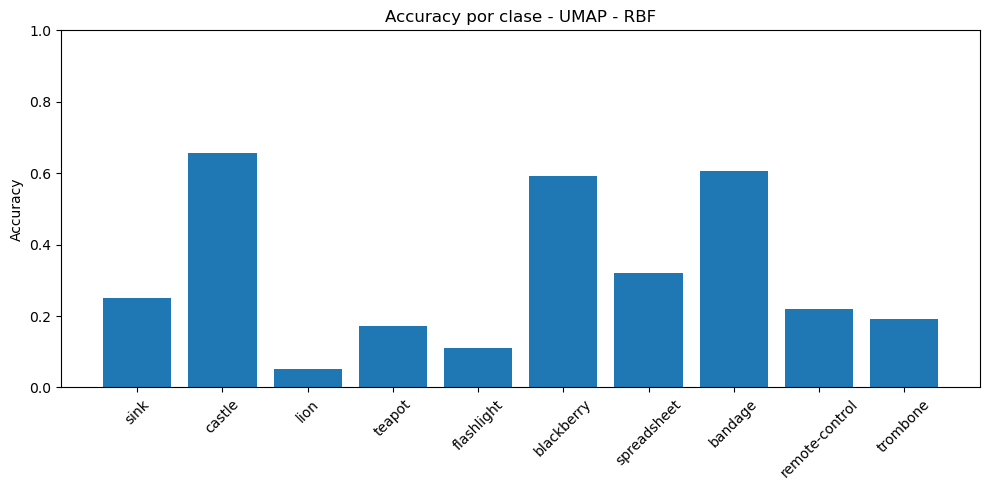

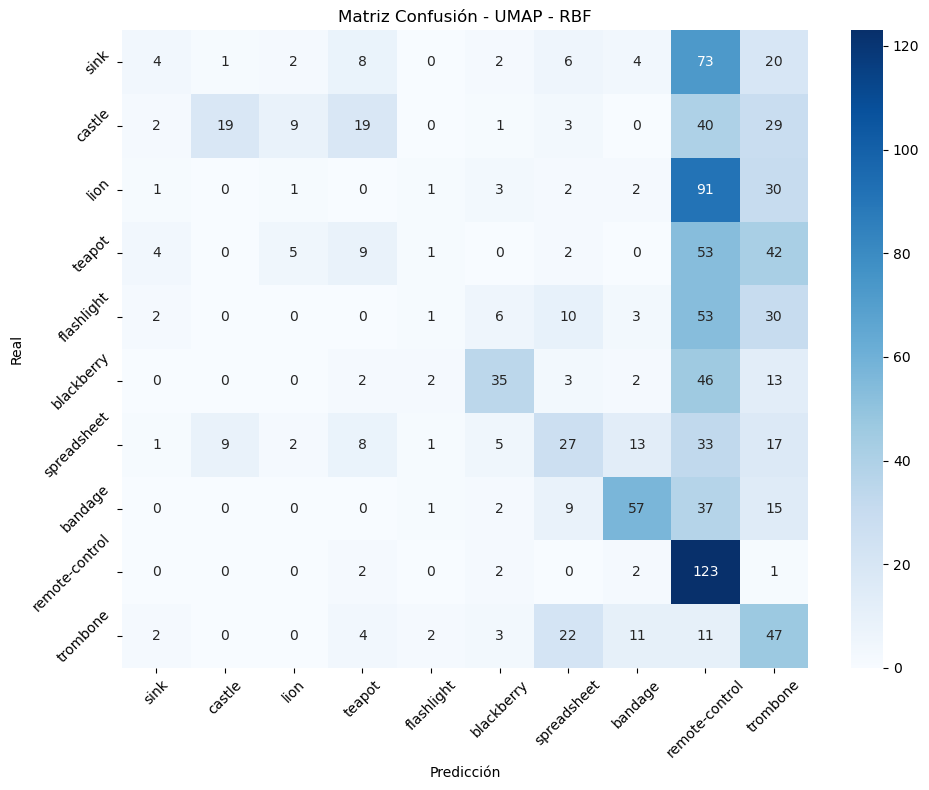


-------------------------------------------------------------------------------


--- UMAP - Poly ---
Accuracy total: 0.2830  || Tiempo total: 2.9651


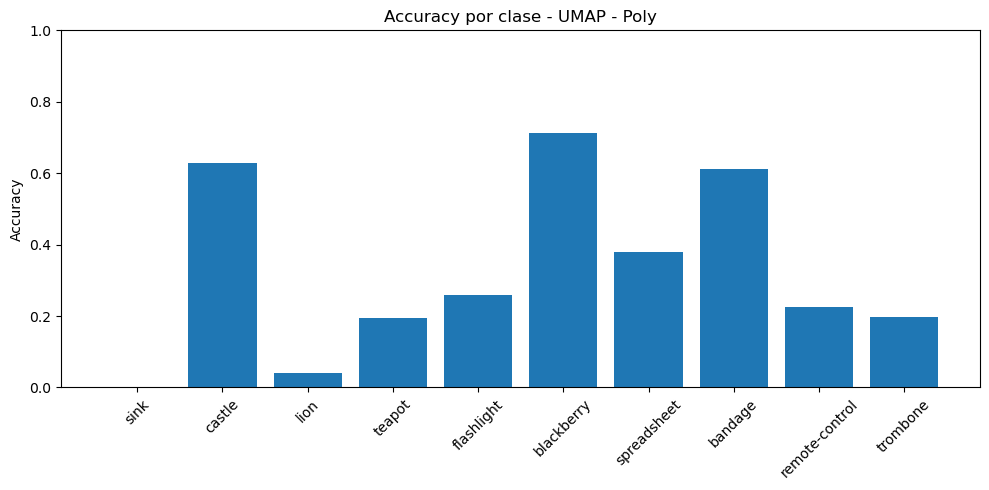

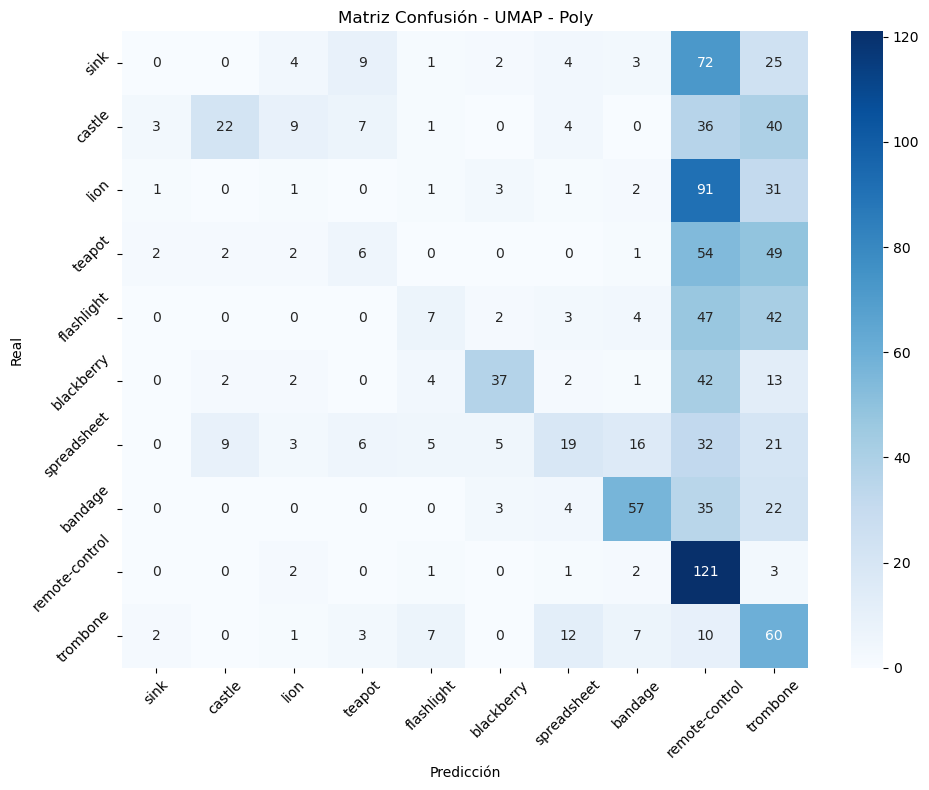

In [20]:
#UMAP
X_train_umap2, X_test_umap2, modelo_umap2 = aplicar_umap(X_train, X_test, n_componentes=50)

modelo_umap_RBF2, acc_umap_rbf2, acc_clase_umap_rbf2, y_pred_umap_rbf2 = probar_modelo(X_train_umap2, y_train, X_test_umap2, y_test, 'rbf', label2name, "UMAP - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_poly2, acc_umap_poly2, acc_clase_umap_poly2, y_pred_umap_poly2 = probar_modelo(X_train_umap2, y_train, X_test_umap2, y_test, 'poly', label2name, "UMAP - Poly")


--- UMAP - RBF ---
Accuracy total: 0.2856  || Tiempo total: 4.6762


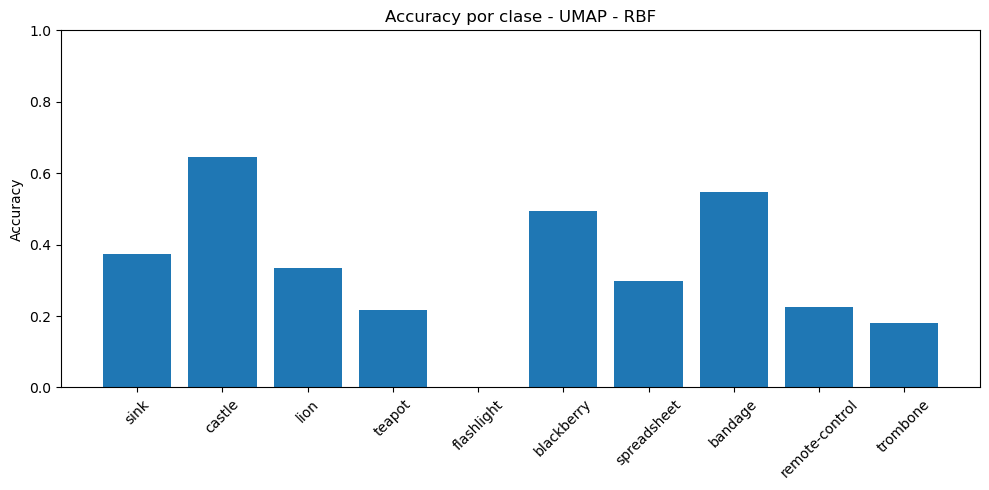

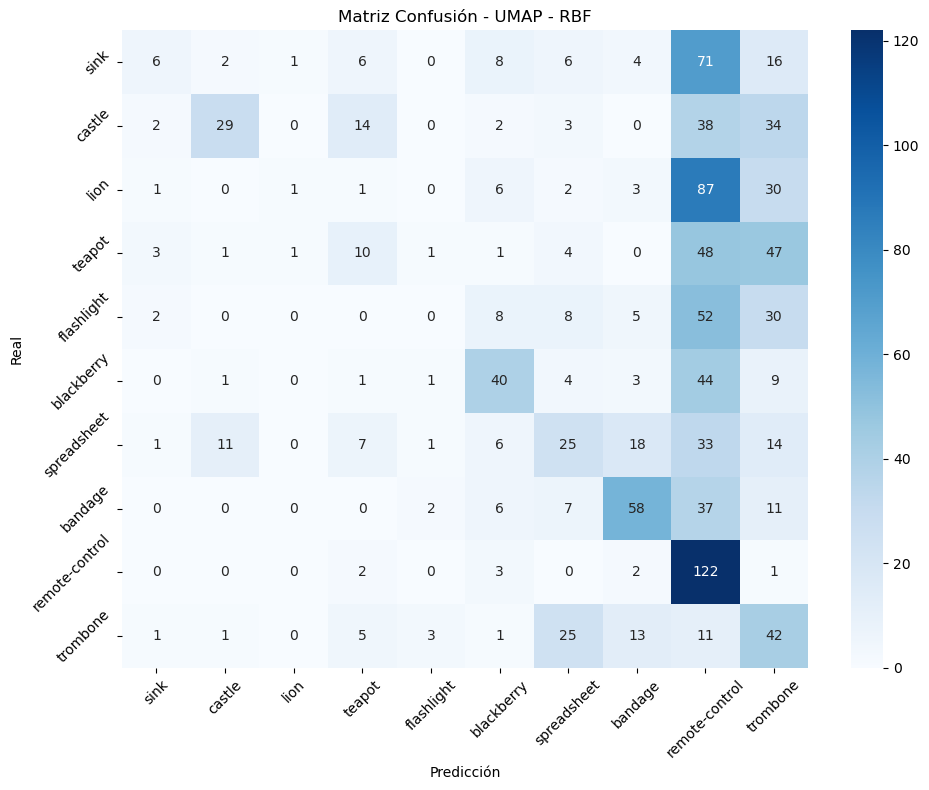


-------------------------------------------------------------------------------


--- UMAP - Poly ---
Accuracy total: 0.2985  || Tiempo total: 3.8557


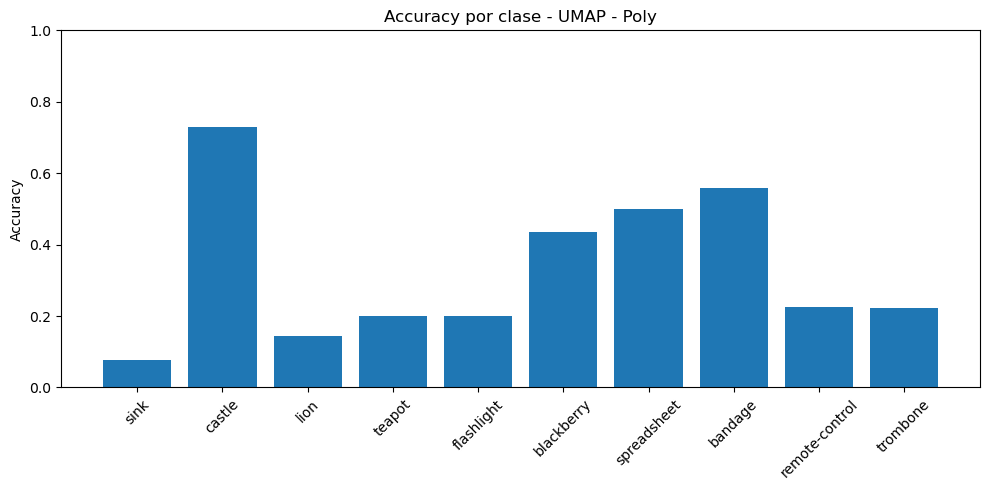

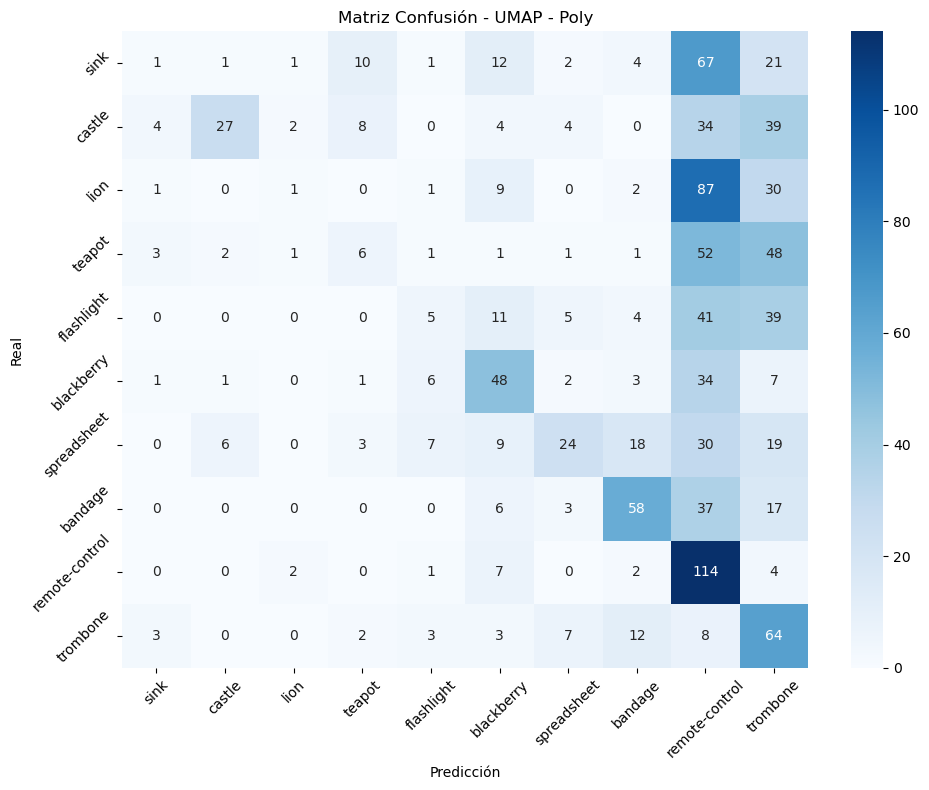

In [21]:
#UMAP
X_train_umap3, X_test_umap3, modelo_umap3 = aplicar_umap(X_train, X_test, n_componentes=100)

modelo_umap_RBF3, acc_umap_rbf3, acc_clase_umap_rbf3, y_pred_umap_rbf3 = probar_modelo(X_train_umap3, y_train, X_test_umap3, y_test, 'rbf', label2name, "UMAP - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_poly3, acc_umap_poly3, acc_clase_umap_poly3, y_pred_umap_poly3 = probar_modelo(X_train_umap3, y_train, X_test_umap3, y_test, 'poly', label2name, "UMAP - Poly")


--- UMAP - RBF ---
Accuracy total: 0.2779  || Tiempo total: 13.4115


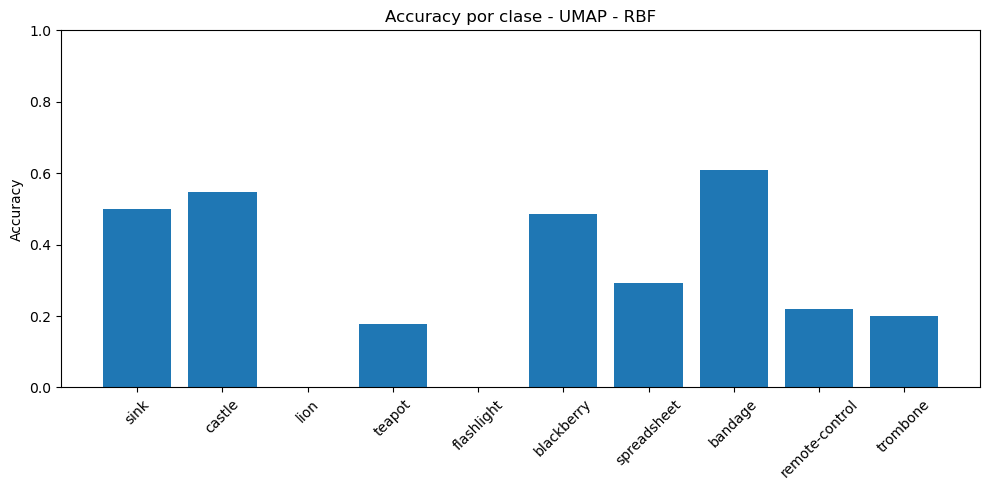

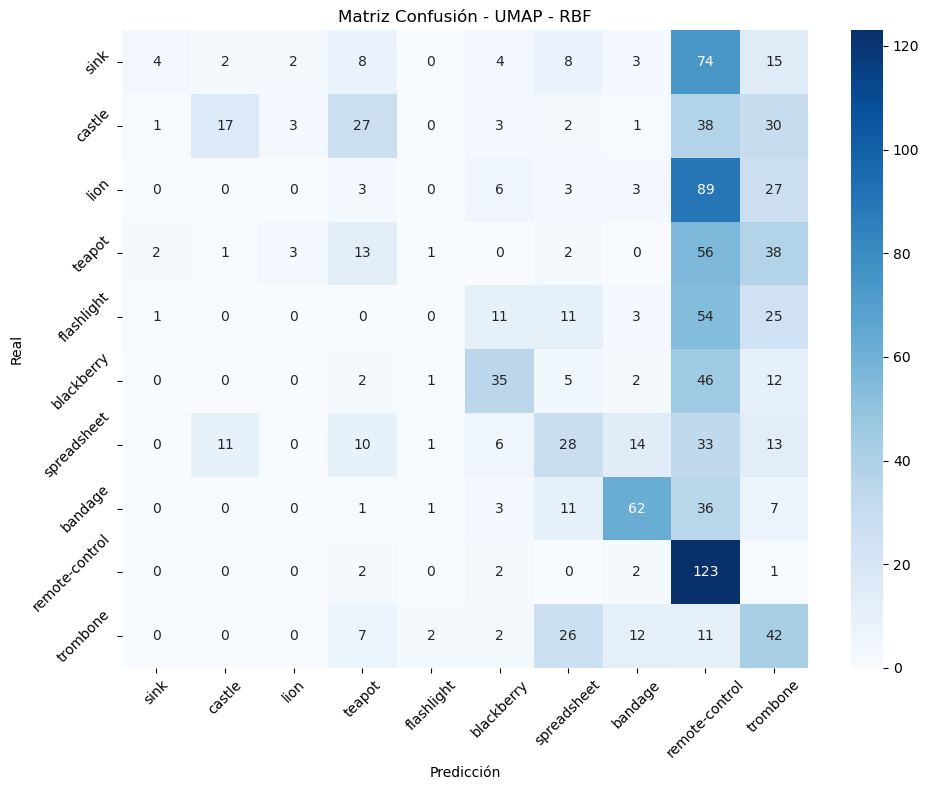


-------------------------------------------------------------------------------


--- UMAP - Poly ---
Accuracy total: 0.2933  || Tiempo total: 10.5354


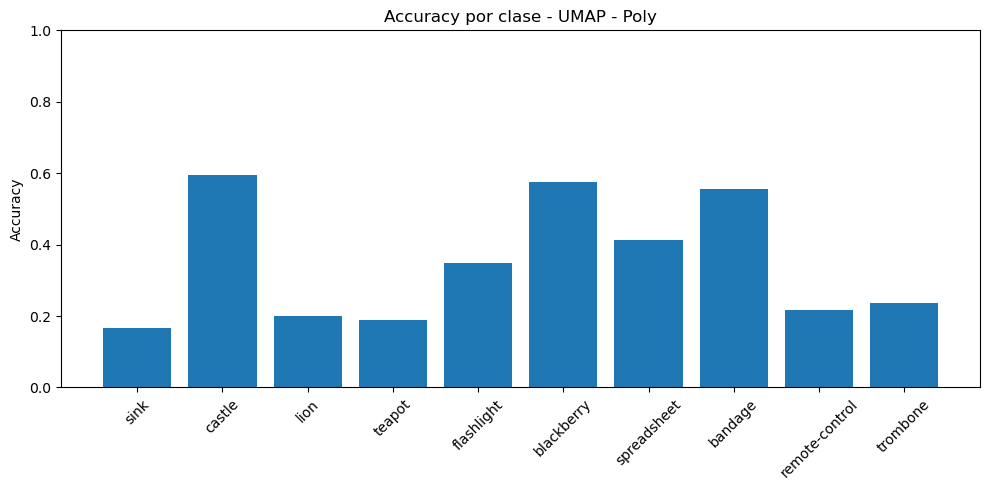

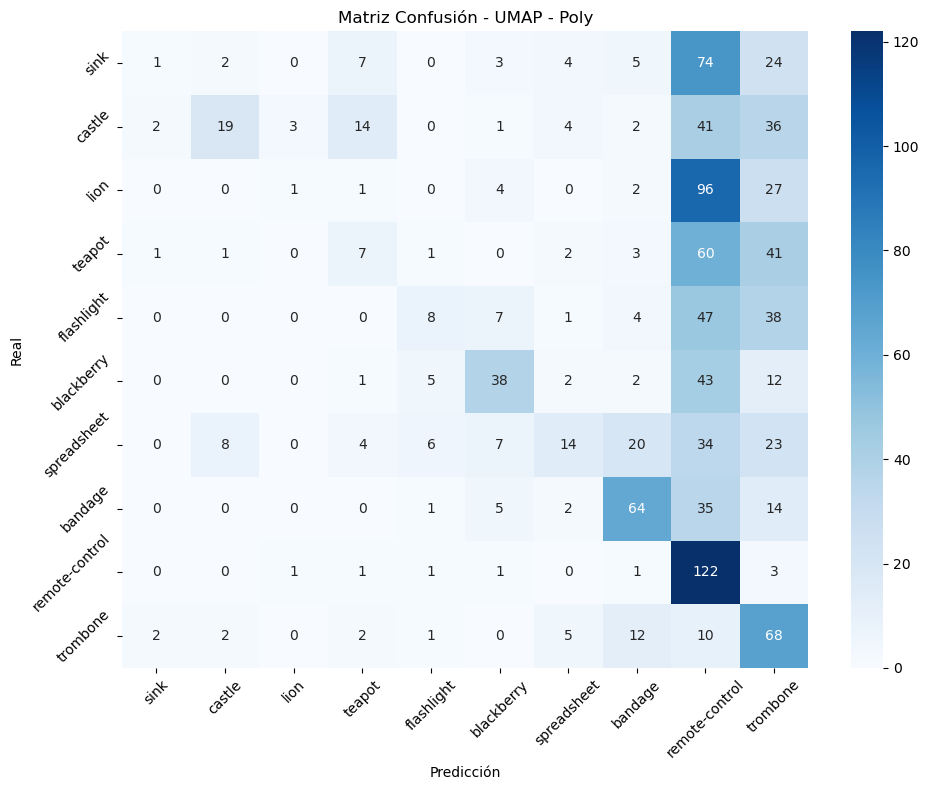

In [26]:
#UMAP
X_train_umap4, X_test_umap4, modelo_umap4 = aplicar_umap(X_train, X_test, n_componentes=500)

modelo_umap_RBF4, acc_umap_rbf4, acc_clase_umap_rbf4, y_pred_umap_rbf4 = probar_modelo(X_train_umap4, y_train, X_test_umap4,y_test, 'rbf', label2name, "UMAP - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_poly4, acc_umap_poly4, acc_clase_umap_poly4, y_pred_umap_poly4 = probar_modelo(X_train_umap4, y_train, X_test_umap4, y_test, 'poly', label2name, "UMAP - Poly")

### Variación en Dim PCA
Se hacen pruebas variando el número de componentes en PCA (10,50,100 y 500)


--- PCA - RBF ---
Accuracy total: 0.7221  || Tiempo total: 3.0386


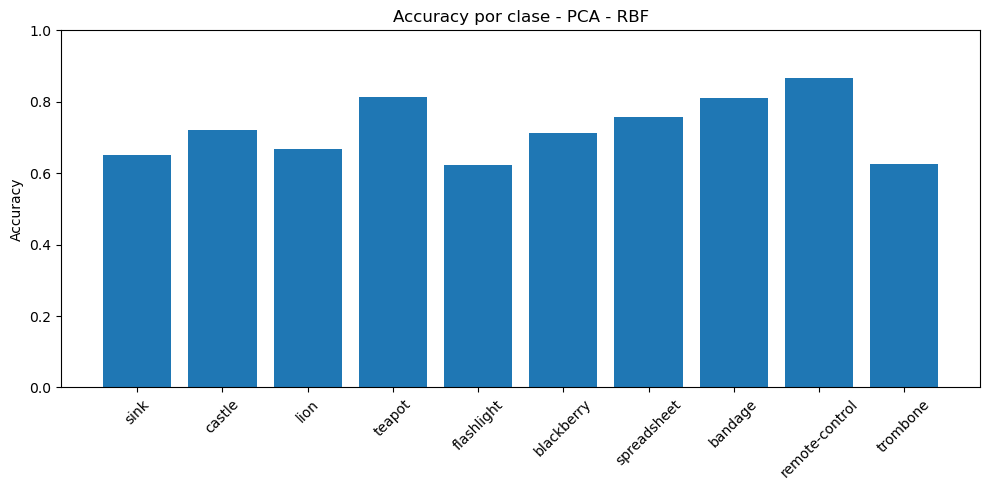

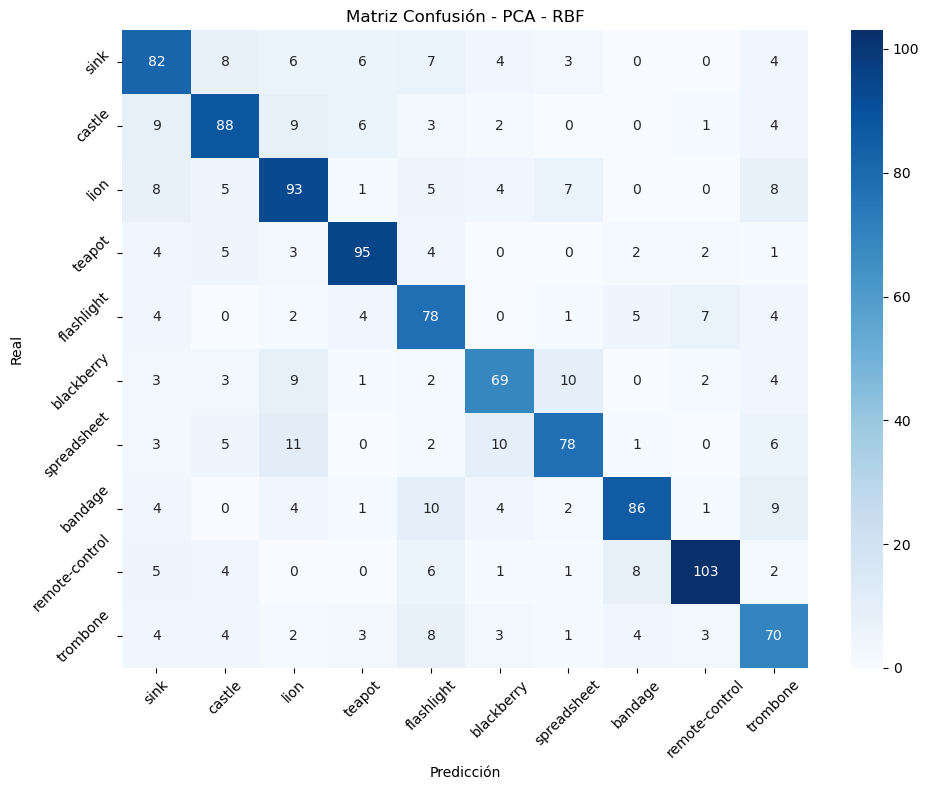


-------------------------------------------------------------------------------


--- PCA - Poly ---
Accuracy total: 0.6724  || Tiempo total: 4.1874


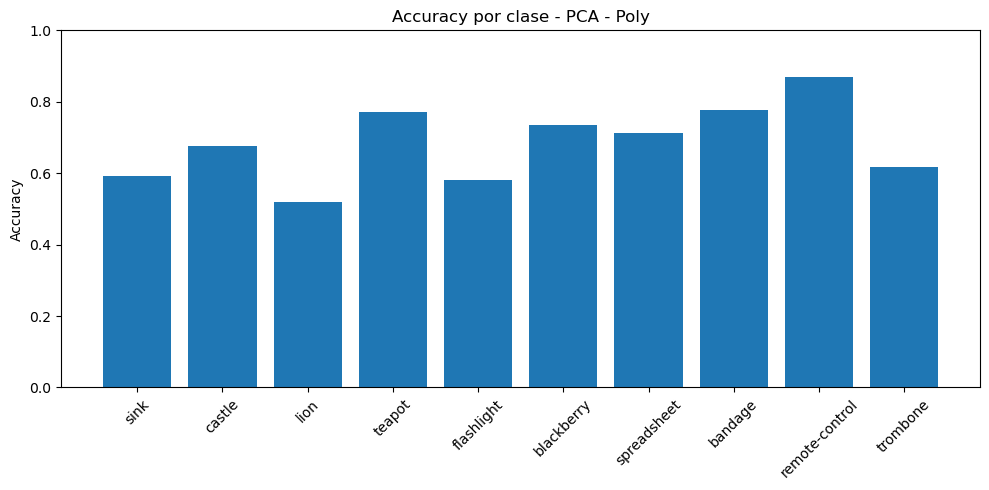

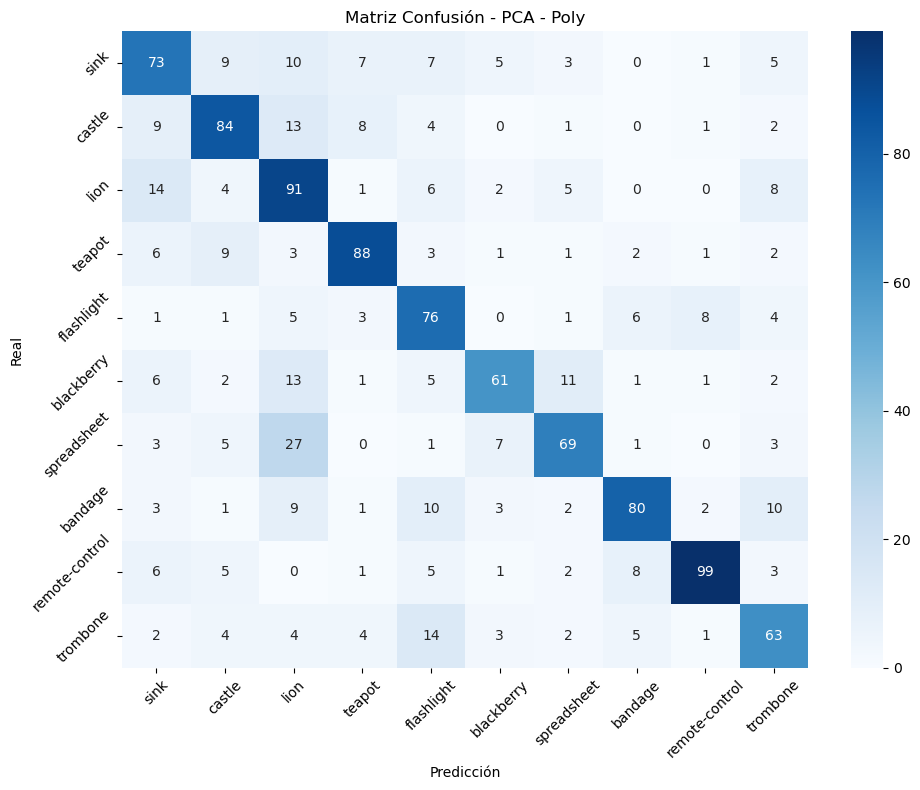

In [22]:
#PCA
X_train_pca1, X_test_pca1, modelo_pca1 = aplicar_pca(X_train, X_test, n_componentes=10)

modelo_pca_RBF1, acc_pca_rbf1, acc_clase_pca_rbf1, y_pred_pca_rbf1 = probar_modelo(X_train_pca1, y_train, X_test_pca1, y_test, 'rbf', label2name, "PCA - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_poly1, acc_pca_poly1, acc_clase_pca_poly1, y_pred_pca_poly1 = probar_modelo(X_train_pca1, y_train, X_test_pca1, y_test, 'poly', label2name, "PCA - Poly")


--- PCA - RBF ---
Accuracy total: 0.8062  || Tiempo total: 3.8830


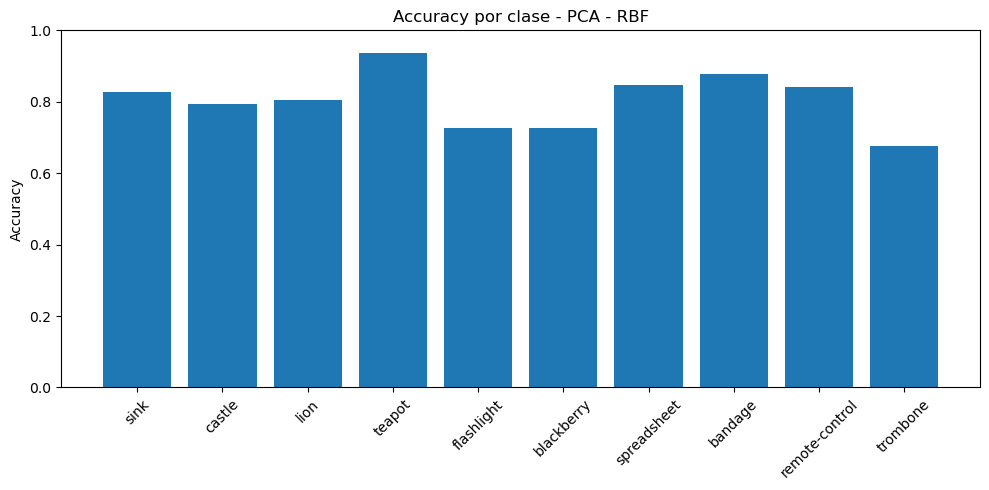

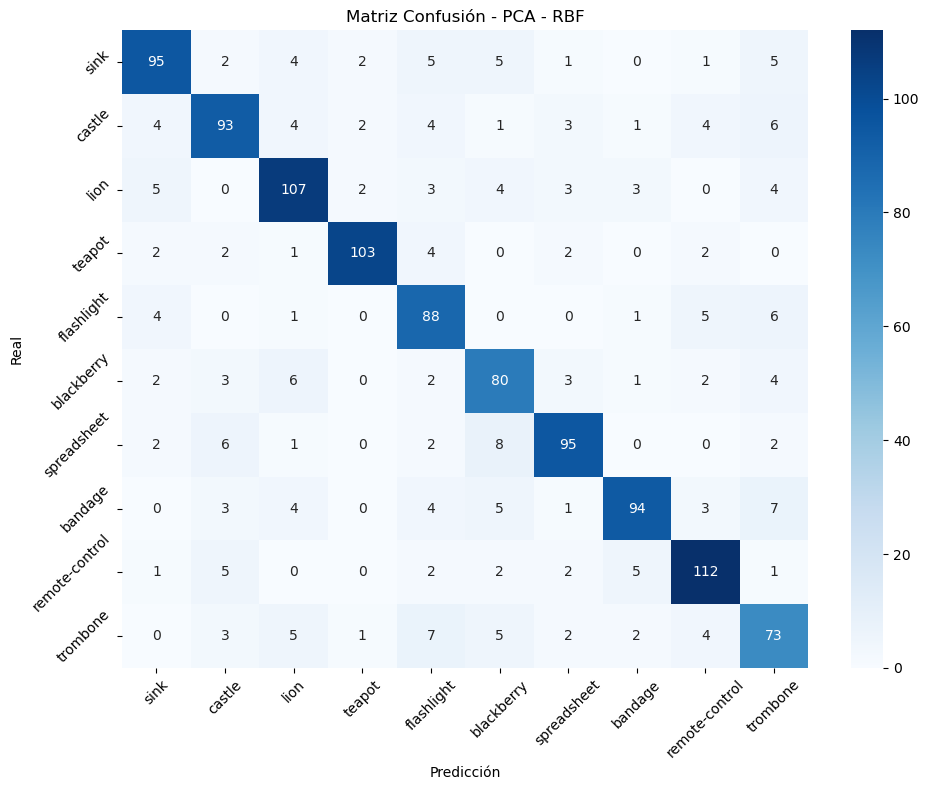


-------------------------------------------------------------------------------


--- PCA - Poly ---
Accuracy total: 0.7633  || Tiempo total: 3.3242


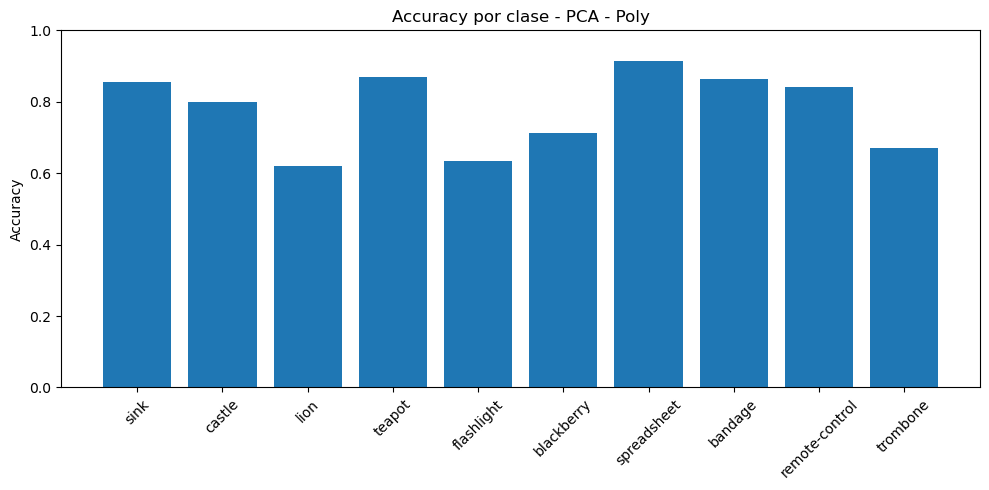

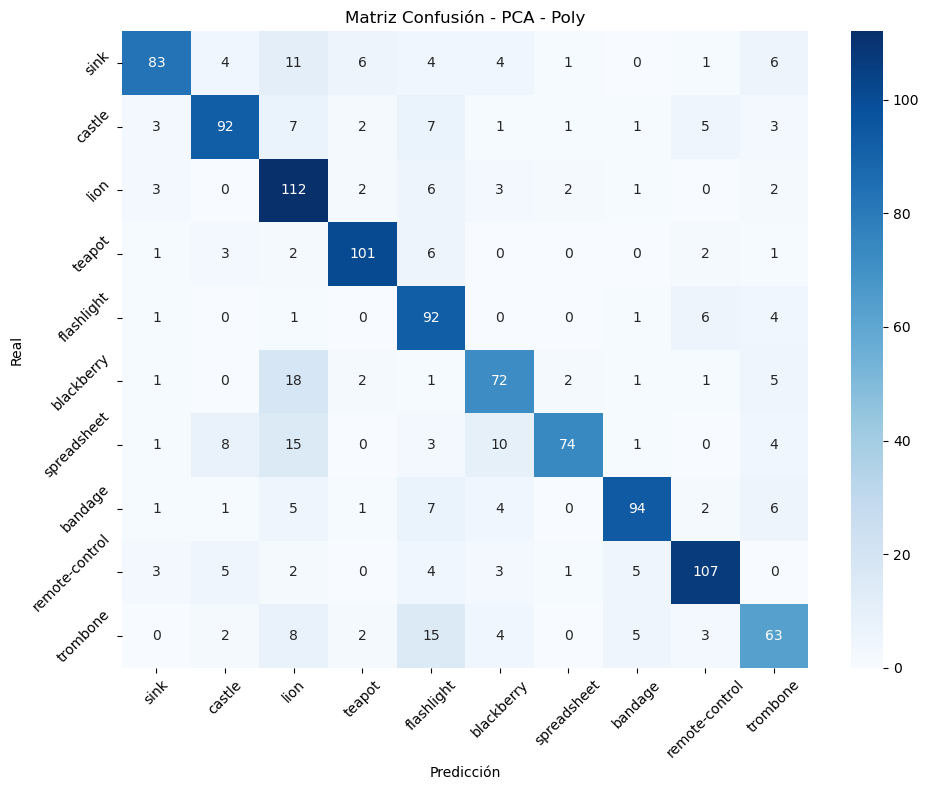

In [23]:
#PCA
X_train_pca2, X_test_pca2, modelo_pca2 = aplicar_pca(X_train, X_test, n_componentes=50)

modelo_pca_RBF2, acc_pca_rbf2, acc_clase_pca_rbf2, y_pred_pca_rbf2 = probar_modelo(X_train_pca2, y_train, X_test_pca2, y_test, 'rbf', label2name, "PCA - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_poly2, acc_pca_poly2, acc_clase_pca_poly2, y_pred_pca_poly2 = probar_modelo(X_train_pca2, y_train, X_test_pca2, y_test, 'poly', label2name, "PCA - Poly")


--- PCA - RBF ---
Accuracy total: 0.7993  || Tiempo total: 5.4578


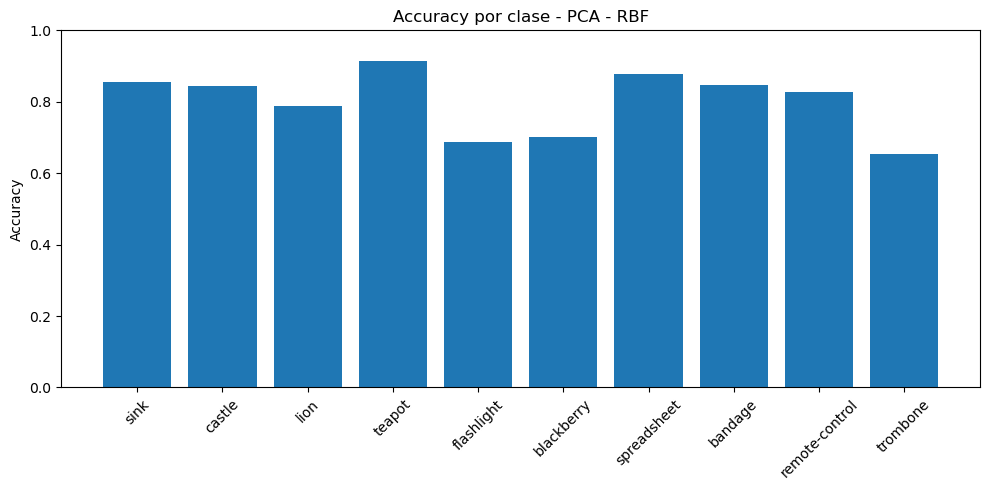

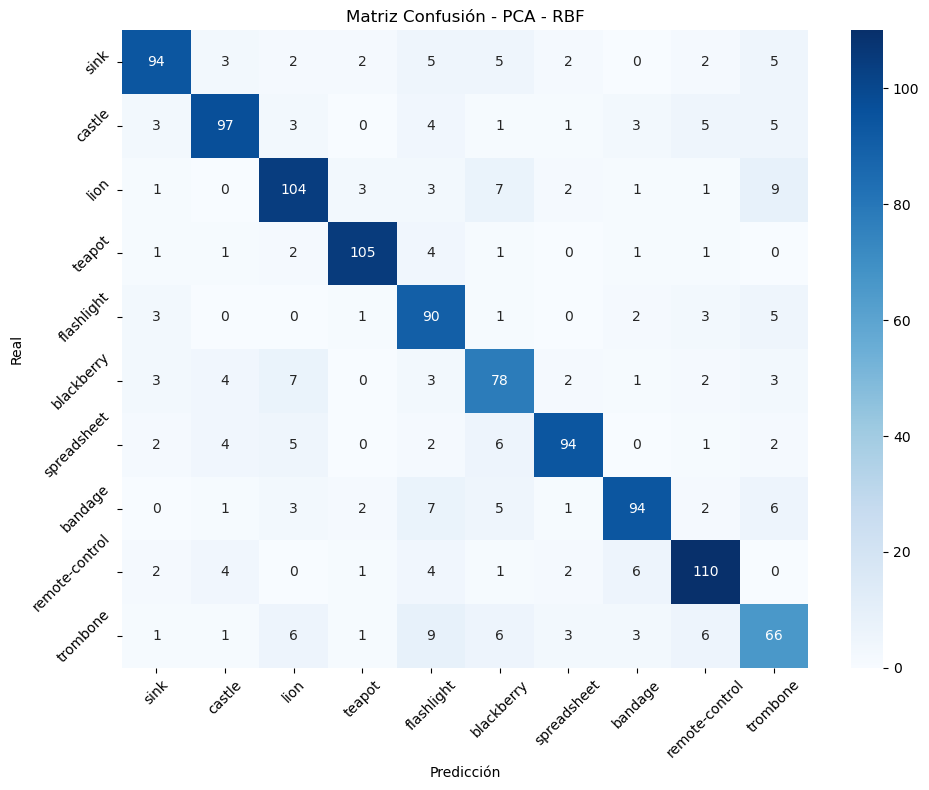


-------------------------------------------------------------------------------


--- PCA - Poly ---
Accuracy total: 0.7539  || Tiempo total: 5.6775


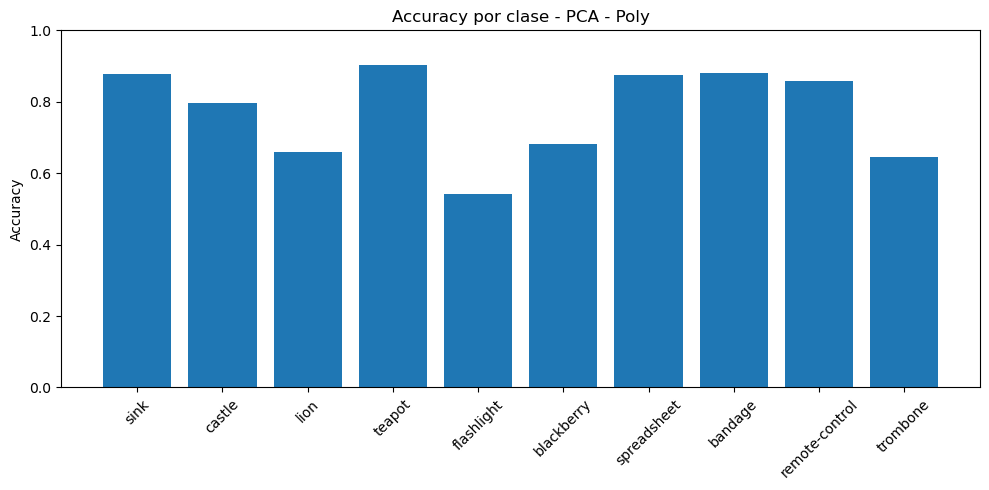

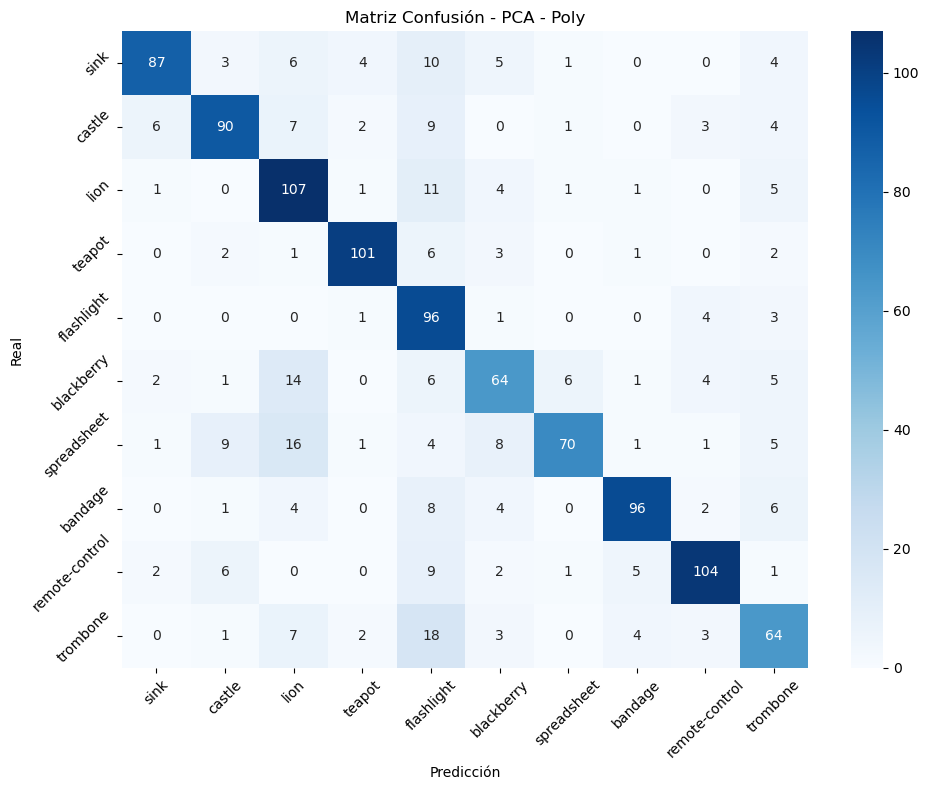

In [24]:
#PCA
X_train_pca3, X_test_pca3, modelo_pca3 = aplicar_pca(X_train, X_test, n_componentes=100)

modelo_pca_RBF3, acc_pca_rbf3, acc_clase_pca_rbf3, y_pred_pca_rbf3 = probar_modelo(X_train_pca3, y_train, X_test_pca3, y_test, 'rbf', label2name, "PCA - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_poly3, acc_pca_poly3, acc_clase_pca_poly3, y_pred_pca_poly3 = probar_modelo(X_train_pca3, y_train, X_test_pca3, y_test, 'poly', label2name, "PCA - Poly")


--- PCA - RBF ---
Accuracy total: 0.7436  || Tiempo total: 17.2799


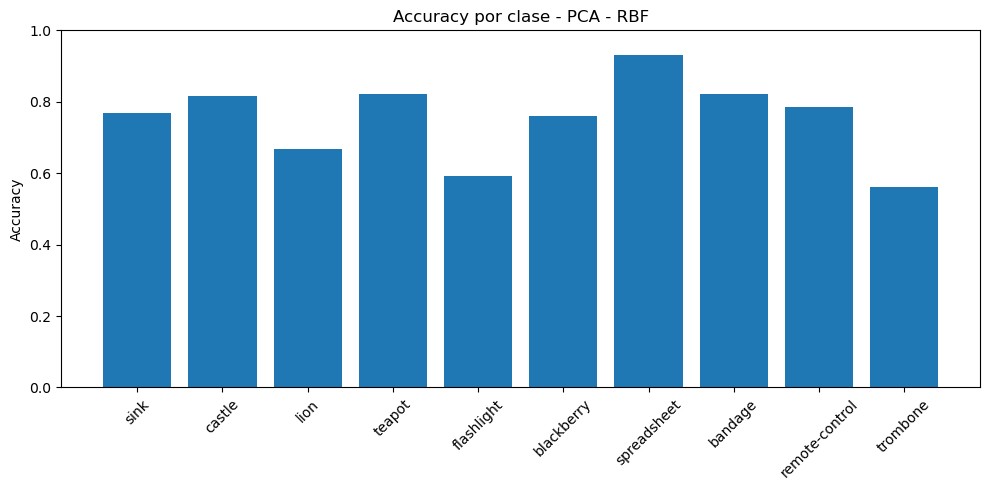

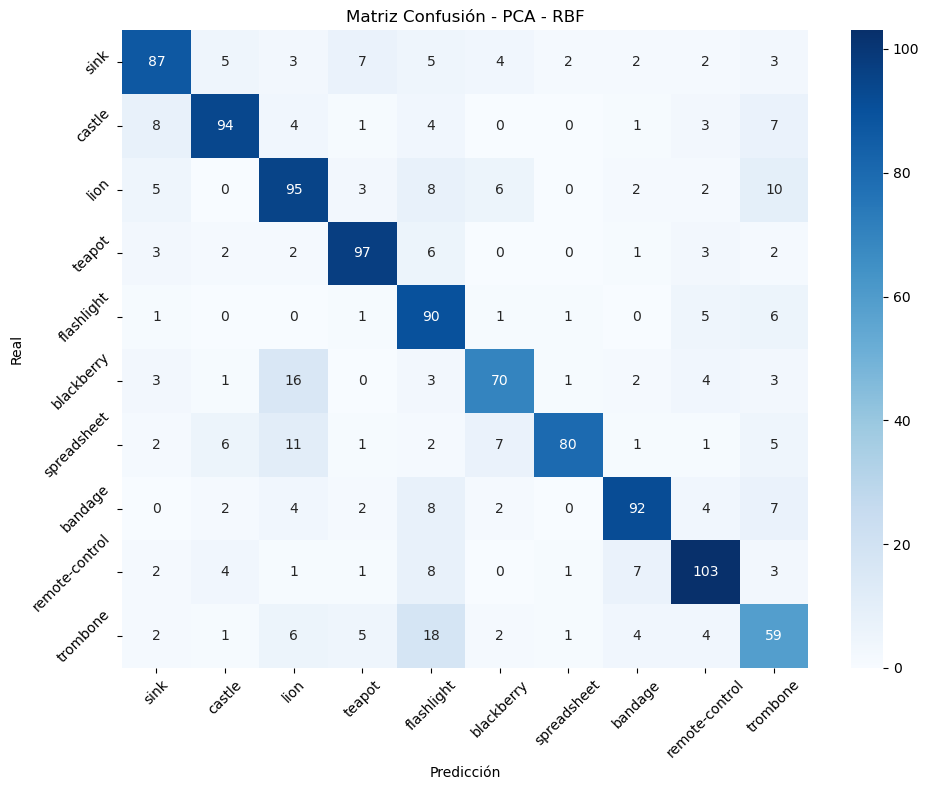


-------------------------------------------------------------------------------


--- PCA - Poly ---
Accuracy total: 0.6441  || Tiempo total: 20.3357


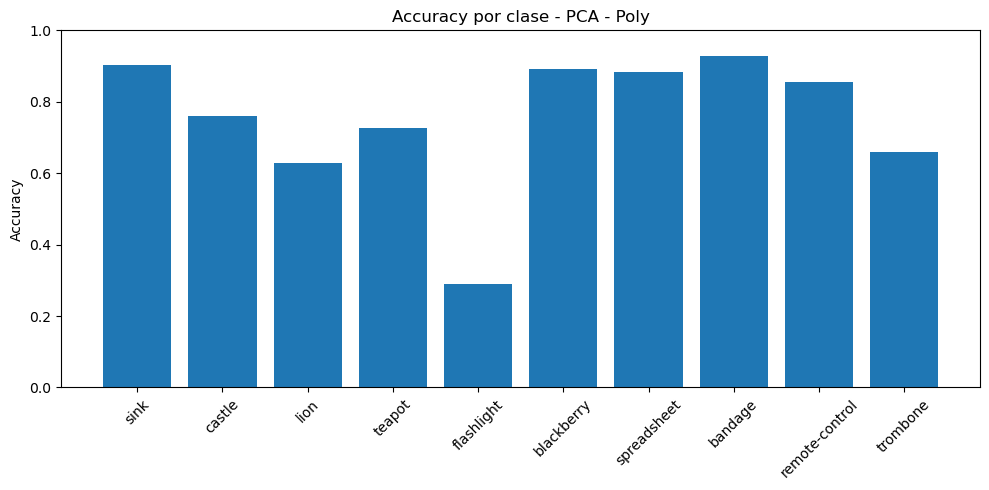

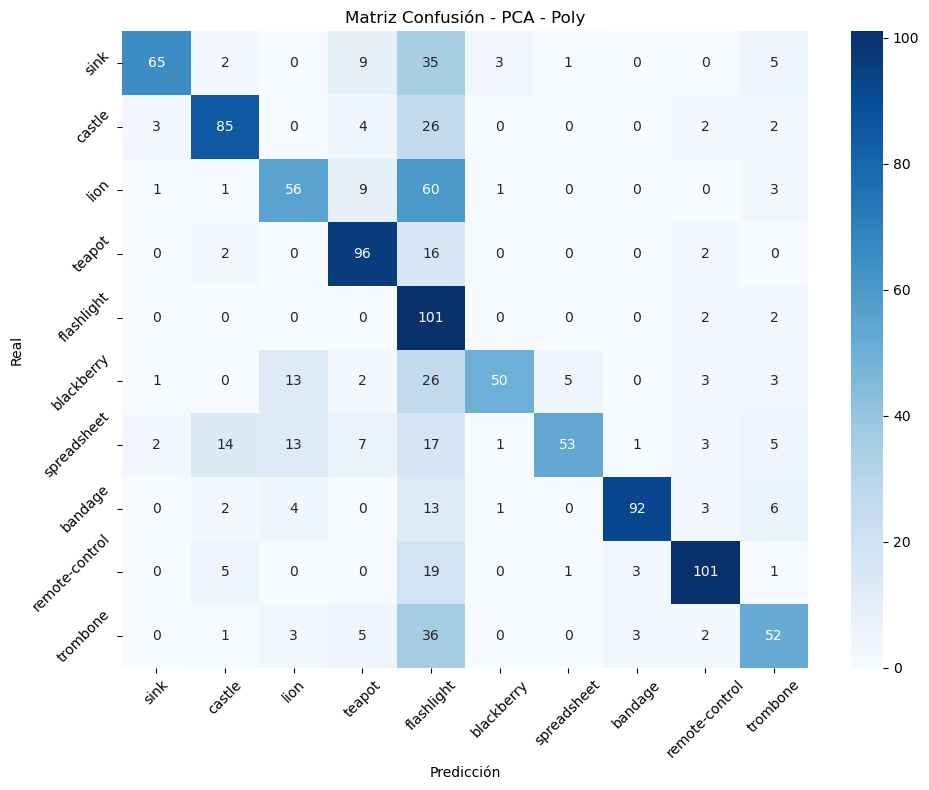

In [25]:
#PCA
X_train_pca4, X_test_pca4, modelo_pca4 = aplicar_pca(X_train, X_test, n_componentes=500)

modelo_pca_RBF4, acc_pca_rbf4, acc_clase_pca_rbf4, y_pred_pca_rbf4 = probar_modelo(X_train_pca4, y_train, X_test_pca4, y_test, 'rbf', label2name, "PCA - RBF")
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_poly4, acc_pca_poly4, acc_clase_pca_poly4, y_pred_pca_poly4 = probar_modelo(X_train_pca4, y_train, X_test_pca4, y_test, 'poly', label2name, "PCA - Poly")

### Variación en C 
Se realizan pruebas variando el valor de C dentro de SVM (0.1, 1.0 y 100.0),  aplicando un mayor o menor castigo a los errores. Con el fin de mantener un tiempo de cómputo razonable, se considerarán únicamente las versiones con kernel rbf ya que son aquellas que muestran mejor rendimiento.

In [ ]:
#Entrenar con imágenes originales
modelo_rbf, acc_rbf, acc_clase_rbf, y_pred_rbf = probar_modelo(X_train, y_train, X_test, y_test, 'rbf', label2name, "Original - RBF C=0.1", 0.1)
print("\n-------------------------------------------------------------------------------\n")
modelo_rbf, acc_rbf, acc_clase_rbf, y_pred_rbf = probar_modelo(X_train, y_train, X_test, y_test, 'rbf', label2name, "Original - RBF C=1.0", 1.0)
print("\n-------------------------------------------------------------------------------\n")
modelo_rbf, acc_rbf, acc_clase_rbf, y_pred_rbf = probar_modelo(X_train, y_train, X_test, y_test, 'rbf', label2name, "Original - RBF C=100.0", 100.0)


--- Original - RBF C=0.1 ---



--- PCA - RBF C=0.1 ---
Accuracy total: 0.7024  || Tiempo total: 10.9237


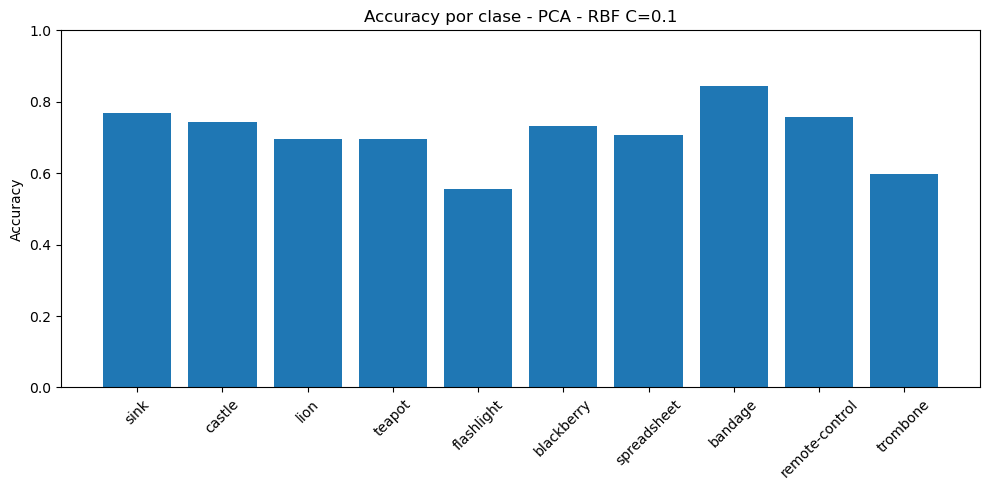

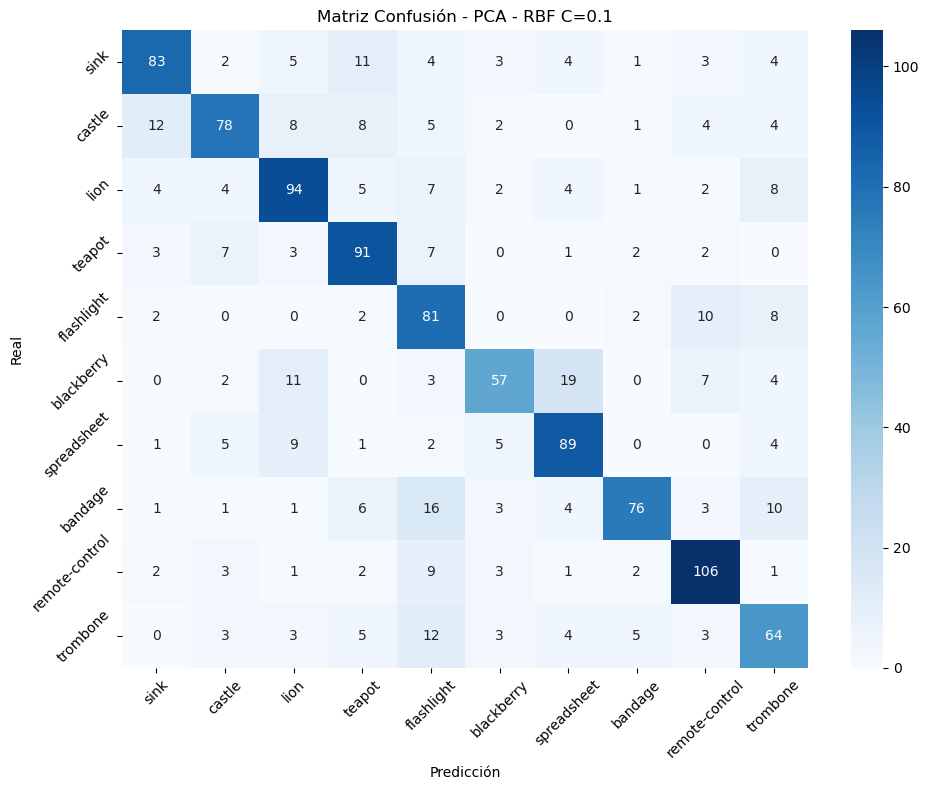


-------------------------------------------------------------------------------


--- PCA - RBF C=1.0 ---
Accuracy total: 0.7693  || Tiempo total: 8.7993


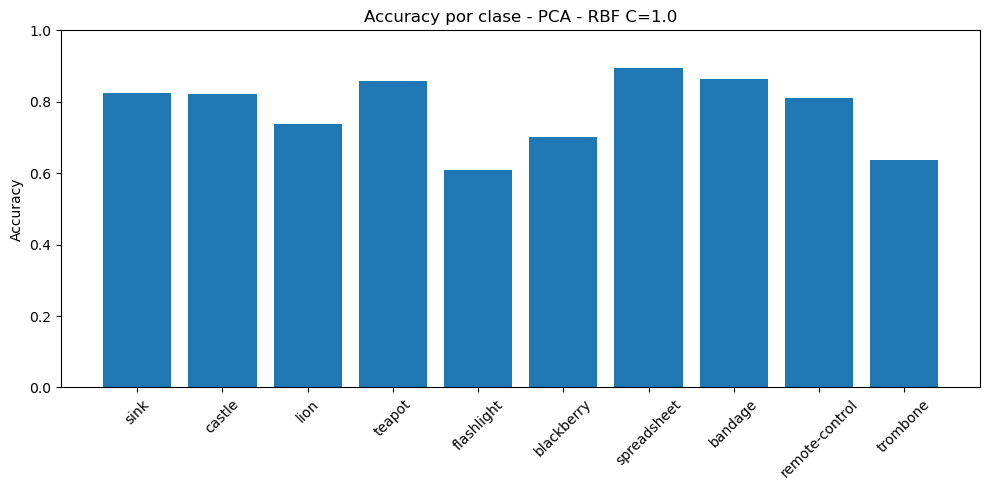

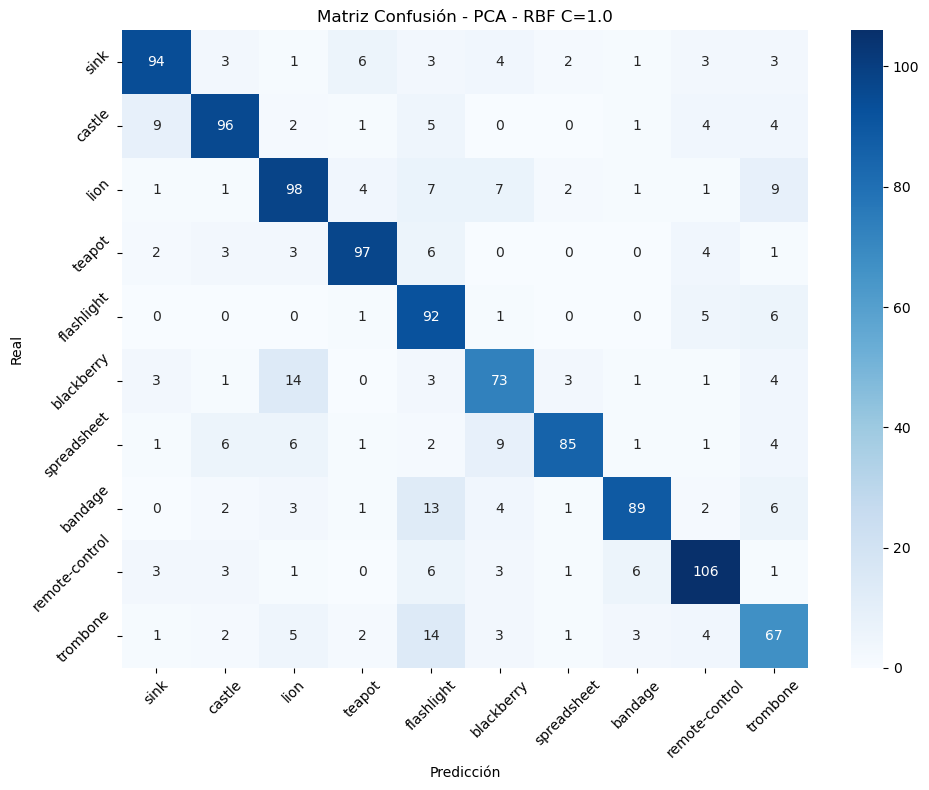


-------------------------------------------------------------------------------


--- PCA - RBF C=100.0 ---
Accuracy total: 0.7787  || Tiempo total: 11.9115


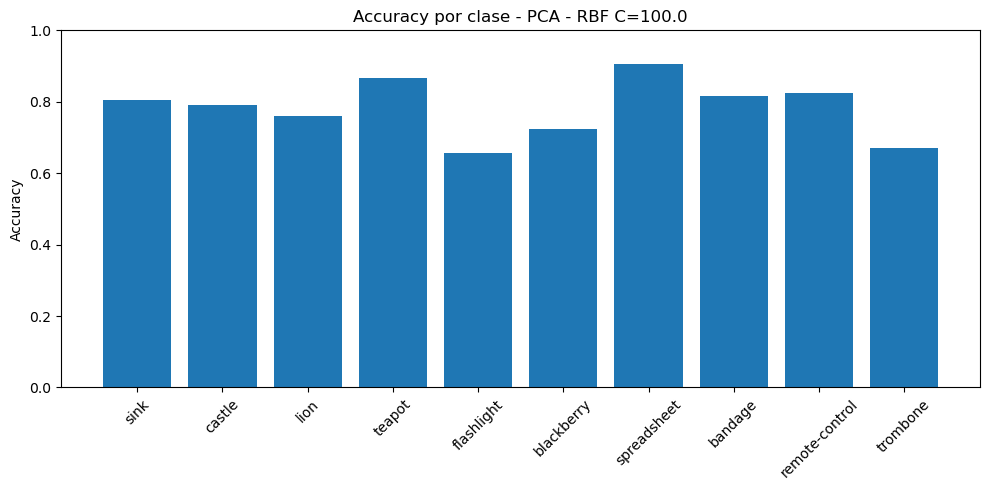

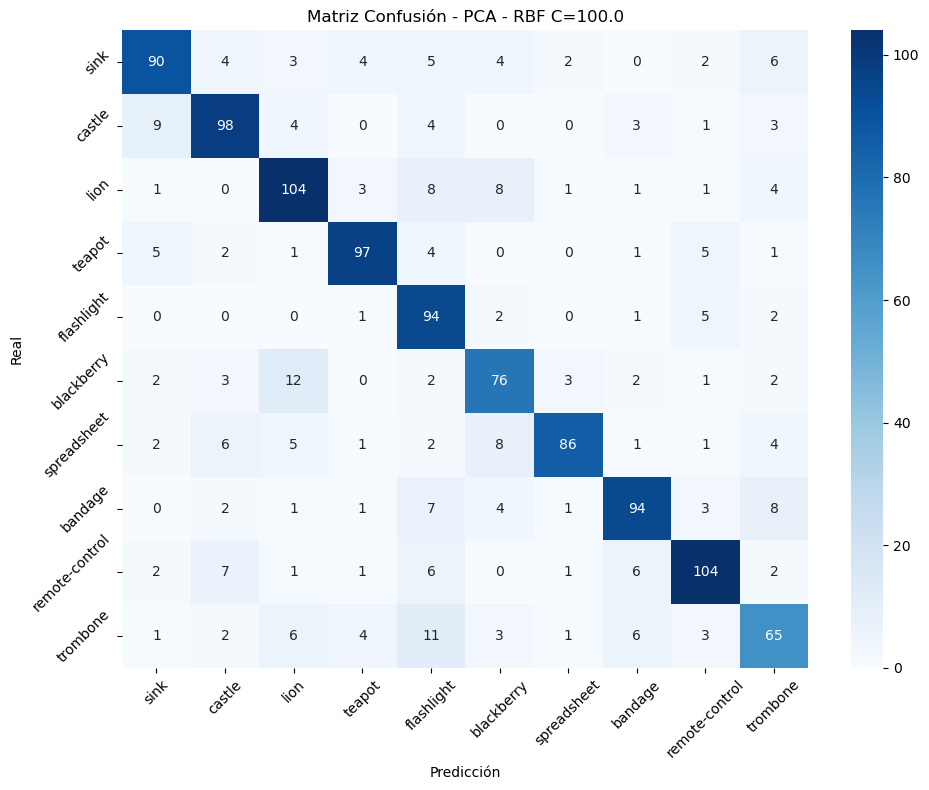

In [10]:
#PCA
X_train_pca, X_test_pca, modelo_pca = aplicar_pca(X_train, X_test, n_componentes=256)

modelo_pca_RBF, acc_pca_rbf, acc_clase_pca_rbf, y_pred_pca_rbf = probar_modelo(X_train_pca, y_train, X_test_pca, y_test, 'rbf', label2name, "PCA - RBF C=0.1", 0.1)
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_RBF, acc_pca_rbf, acc_clase_pca_rbf, y_pred_pca_rbf = probar_modelo(X_train_pca, y_train, X_test_pca, y_test, 'rbf', label2name, "PCA - RBF C=1.0", 1.0)
print("\n-------------------------------------------------------------------------------\n")
modelo_pca_RBF, acc_pca_rbf, acc_clase_pca_rbf, y_pred_pca_rbf = probar_modelo(X_train_pca, y_train, X_test_pca, y_test, 'rbf', label2name, "PCA - RBF C=100.0", 100.0)


--- UMAP - RBF C=0.1 ---
Accuracy total: 0.2599  || Tiempo total: 15.4284


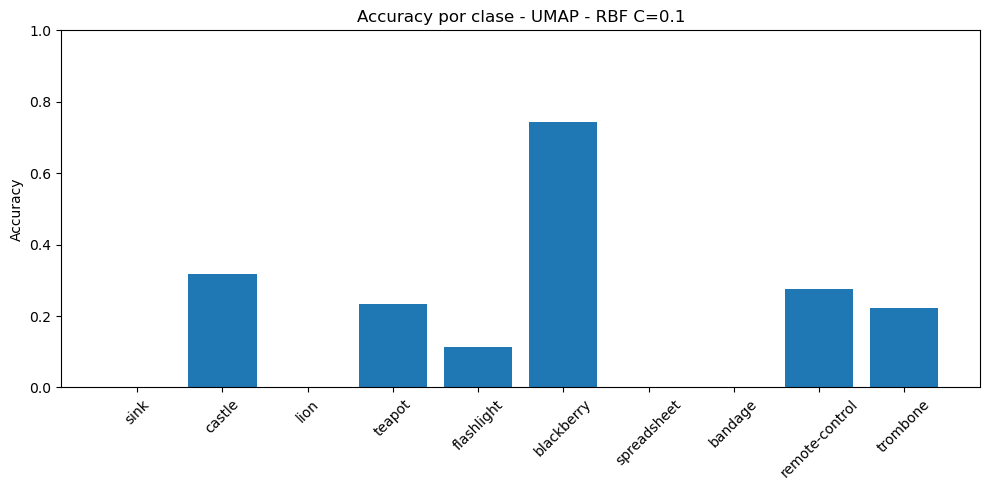

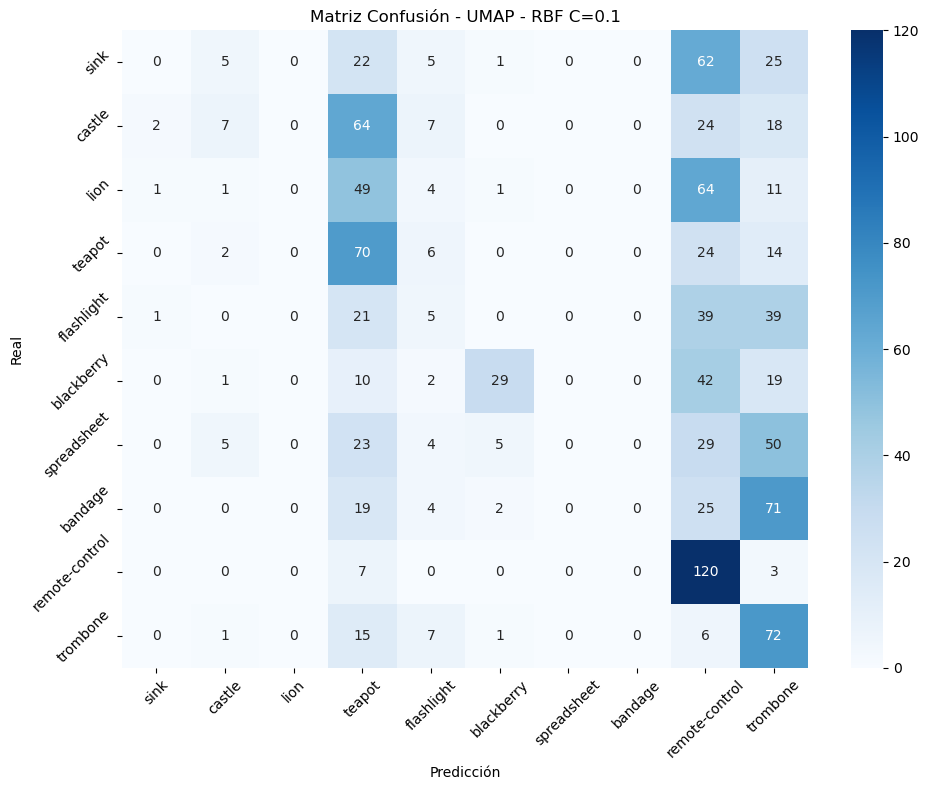


-------------------------------------------------------------------------------


--- UMAP - RBF C=1.0 ---
Accuracy total: 0.2933  || Tiempo total: 11.7341


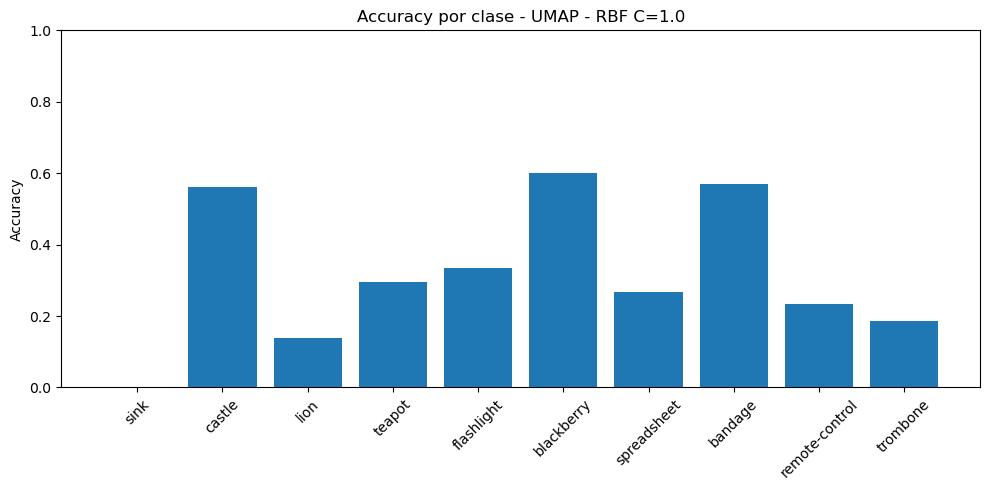

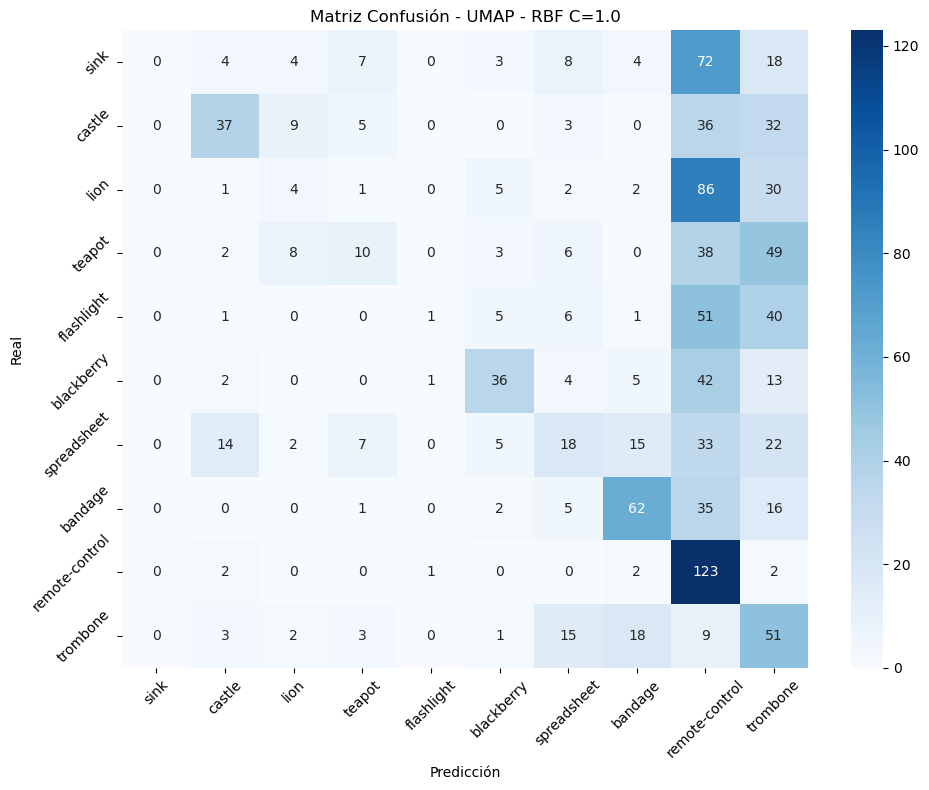


-------------------------------------------------------------------------------


--- UMAP - RBF C=100.0 ---
Accuracy total: 0.2882  || Tiempo total: 6.7671


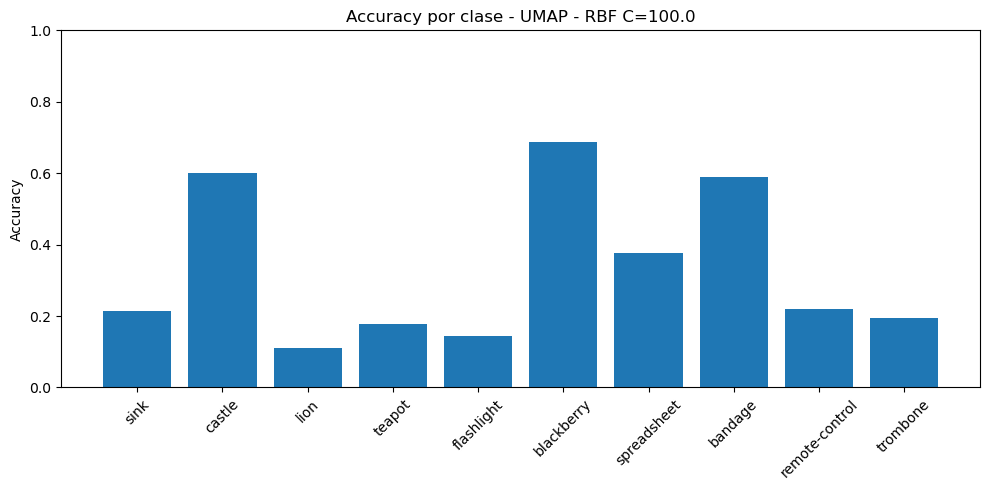

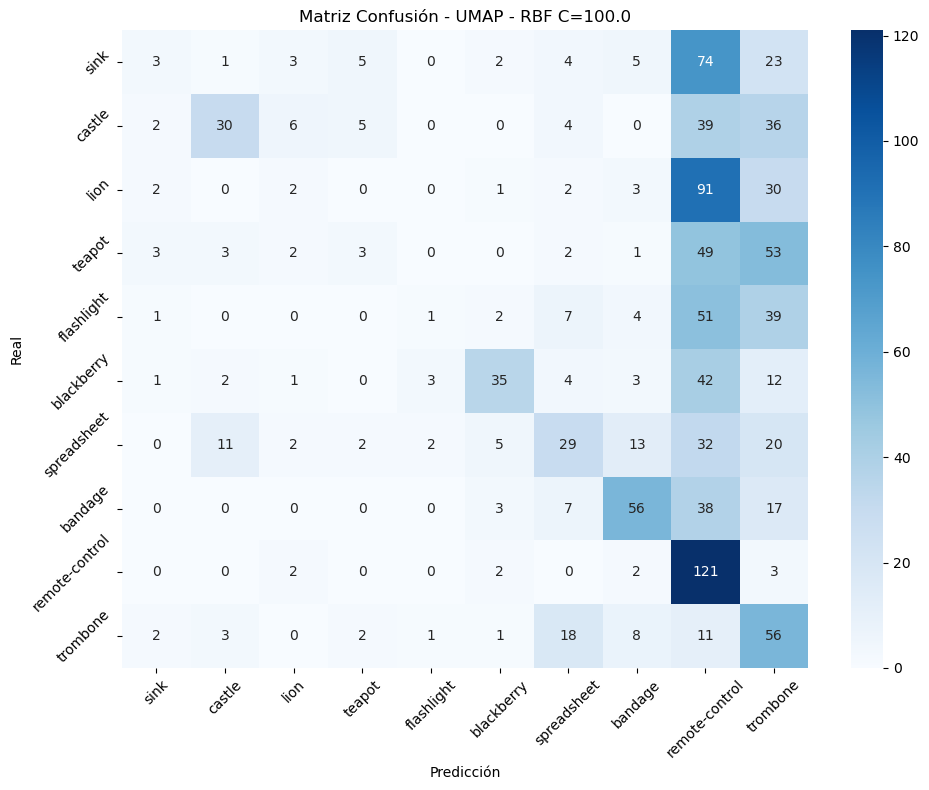

In [11]:
#UMAP
X_train_umap, X_test_umap, modelo_umap = aplicar_umap(X_train, X_test, n_componentes=256)

modelo_umap_RBF, acc_umap_rbf, acc_clase_umap_rbf, y_pred_umap_rbf = probar_modelo(X_train_umap, y_train, X_test_umap, y_test, 'rbf', label2name, "UMAP - RBF C=0.1", 0.1)
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_RBF, acc_umap_rbf, acc_clase_umap_rbf, y_pred_umap_rbf = probar_modelo(X_train_umap, y_train, X_test_umap, y_test, 'rbf', label2name, "UMAP - RBF C=1.0", 1.0)
print("\n-------------------------------------------------------------------------------\n")
modelo_umap_RBF, acc_umap_rbf, acc_clase_umap_rbf, y_pred_umap_rbf = probar_modelo(X_train_umap, y_train, X_test_umap, y_test, 'rbf', label2name, "UMAP - RBF C=100.0", 100.0)